In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm.notebook import tqdm, trange
import seaborn as sns
from PIL import Image

In [2]:
def length_of_rbc(cnt):
    ellipse = cv2.fitEllipse(cnt)
    length = max(ellipse[1])
    return length


def width_of_rbc(cnt):
    ellipse = cv2.fitEllipse(cnt)
    width = min(ellipse[1])
    return width


def area_of_rbc(cnt):
    area = cv2.contourArea(cnt)
    return area

In [3]:
area_limits = (166, 2781)
length_limits = (18, 90)
DI_limits = (101, 384)

# Обработка человеком

In [4]:
images_path = r'C:\Users\gorod\Desktop\2024-10-17'
human_path = r'C:\Users\gorod\Desktop\2024-10-17\human'

In [5]:
npy_files = [os.path.join(images_path, file) for file in os.listdir(images_path) if ".npy" in file]

## Пример гистограммы (DI, площадь, длина)

Количество клеток на изображении 201


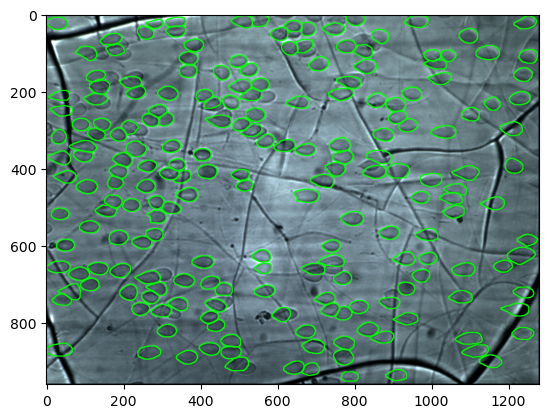

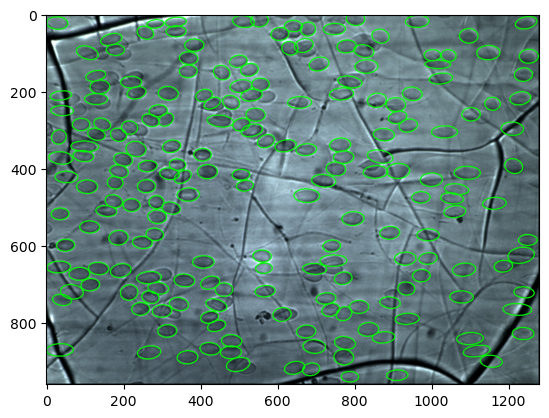

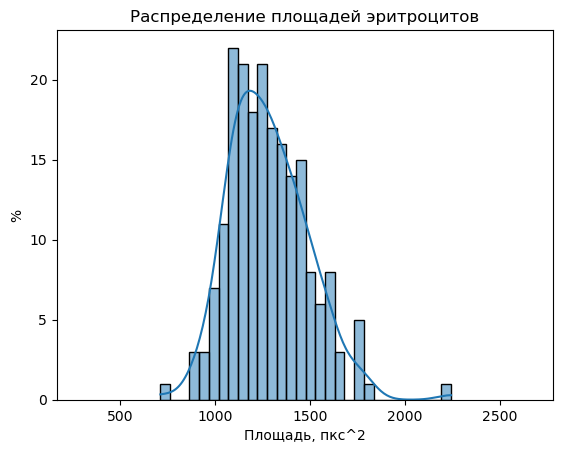

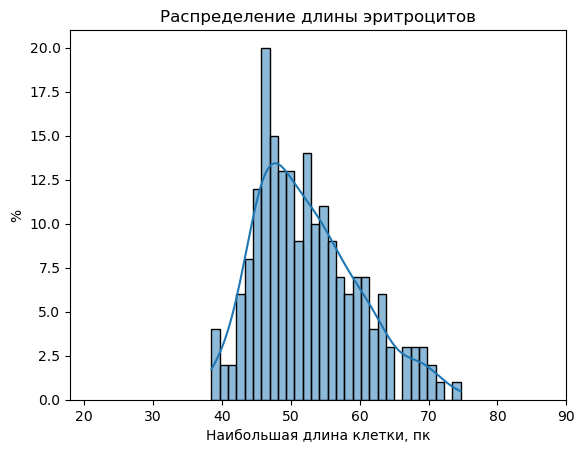

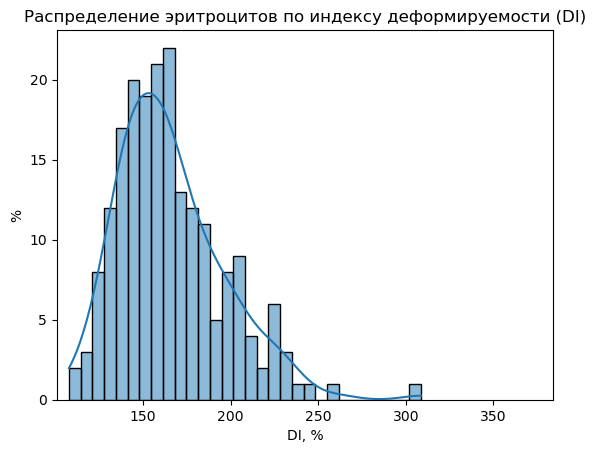

In [7]:
# чтение масок
npy_file = r'C:\Users\gorod\Desktop\2024-10-17\2024-10-17 15-36-43_2014_seg.npy'
npy_data = np.load(npy_file, allow_pickle=True).item()
masks = npy_data['masks']
print("Количество клеток на изображении", masks.max())

# нахождение контуров
image_file = r'C:\Users\gorod\Desktop\2024-10-17\2024-10-17 15-36-43_2014.jpg'
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
contours = []
areas = []
lengths = []
widths = []
DI = []
for i in range(1, masks.max()+1):
    mask = masks.copy()
    mask[mask != i] = 0
    mask[mask == i] = 1
    mask = np.array(mask, np.uint8)
    contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
    cnt = contour[0]
    contours.append(cnt)
    areas.append(area_of_rbc(cnt))
    lengths.append(length_of_rbc(cnt))
    widths.append(width_of_rbc(cnt))
    DI.append(lengths[-1]/widths[-1]*100)
image_with_countours = image.copy() # чтобы не менять оригинал
image_with_countours = cv2.drawContours(image_with_countours, contours, -1, (0,255,0), 2)
plt.imshow(image_with_countours)
plt.show()

# отображение эллипсов
ellipses = []
image_with_ellipses = image.copy() # чтобы не менять оригинал
for cnt in contours:
    # rect = cv2.minAreaRect(cnt)
    ellipse = cv2.fitEllipse(cnt)
    ellipses.append(ellipse)
    # draw_min_area_rect(image_with_rects, ellipse)
    cv2.ellipse(image_with_ellipses, ellipse, (0, 255, 0), 2)
plt.imshow(image_with_ellipses)
plt.show()

# Распределение по площадям
bins = 30
sns.histplot(areas, bins=bins, kde=True)
plt.title('Распределение площадей эритроцитов')
plt.xlabel('Площадь, пкс^2')
plt.ylabel('%')
plt.xlim(area_limits)
plt.show()

# Распределение по длинам
sns.histplot(lengths, bins=bins, kde=True)
plt.title('Распределение длины эритроцитов')
plt.xlabel('Наибольшая длина клетки, пк')
plt.ylabel('%')
plt.xlim(length_limits)
plt.show()

# Распределение по DI
sns.histplot(DI, bins=bins, kde=True)
plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
plt.xlabel('DI, %')
plt.ylabel('%')
plt.xlim(DI_limits)
plt.show()

## Сохранение гистограммы для каждого изображения

In [8]:
human_cells_count = 0 # количество клеток на всех изображениях

for npy_file in tqdm(npy_files):
    npy_filename = os.path.basename(npy_file)[:-8] # имя файла без расширения
    
    # чтение масок
    npy_data = np.load(npy_file, allow_pickle=True).item()
    masks = npy_data['masks']
    human_cells_count += masks.max()

    # нахождение контуров
    image_path = os.path.join(images_path, npy_filename + ".jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    contours = []
    areas = []
    lengths = []
    widths = []
    DI = []
    for i in range(1, masks.max()+1):
        mask = masks.copy()
        mask[mask != i] = 0
        mask[mask == i] = 1
        mask = np.array(mask, np.uint8)
        contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
        cnt = contour[0]
        contours.append(cnt)
        areas.append(area_of_rbc(cnt))
        lengths.append(length_of_rbc(cnt))
        widths.append(width_of_rbc(cnt))
        DI.append(lengths[-1]/widths[-1]*100)
    image_with_countours = cv2.drawContours(image, contours, -1, (0,255,0), 2)
    plt.imshow(image_with_countours)
    plt.savefig(os.path.join(human_path, npy_filename + f"_1_countours ({masks.max()}).png"))
    plt.clf()

    # Распределение по площадям
    bins = 30
    sns.histplot(areas, bins=bins, kde=True)
    plt.title('Распределение площадей эритроцитов')
    plt.xlabel('Площадь, пкс^2')
    plt.ylabel('%')
    plt.xlim(area_limits)
    plt.savefig(os.path.join(human_path, npy_filename + "_2_areas.png"))
    plt.clf()

    # Распределение по длинам
    sns.histplot(lengths, bins=bins, kde=True)
    plt.title('Распределение длины эритроцитов')
    plt.xlabel('Наибольшая длина клетки, пк')
    plt.ylabel('%')
    plt.xlim(length_limits)
    plt.savefig(os.path.join(human_path, npy_filename + "_3_lengths.png"))
    plt.clf()

    # Распределение по DI
    sns.histplot(DI, bins=bins, kde=True)
    plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
    plt.xlabel('DI, %')
    plt.ylabel('%')
    plt.xlim(DI_limits)
    plt.savefig(os.path.join(human_path, npy_filename + "_4_DI.png"))
    plt.clf()
plt.close()

print(f"Обработано {len(npy_files)} изображений")
print('Всего клеток на изображениях: ', human_cells_count)

  0%|          | 0/33 [00:00<?, ?it/s]

Обработано 33 изображений
Всего клеток на изображениях:  5285


## Гистограмма по всем изображениям

  0%|          | 0/33 [00:00<?, ?it/s]

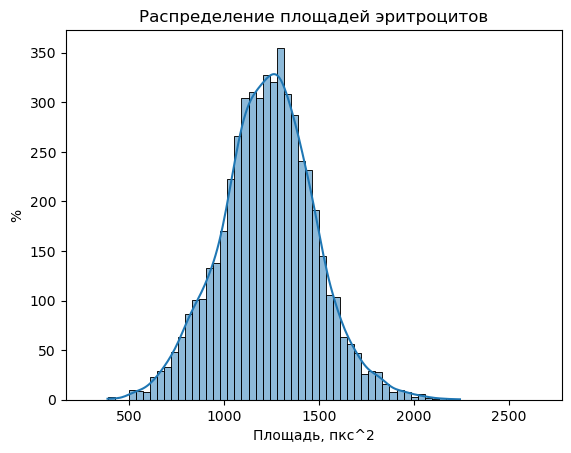

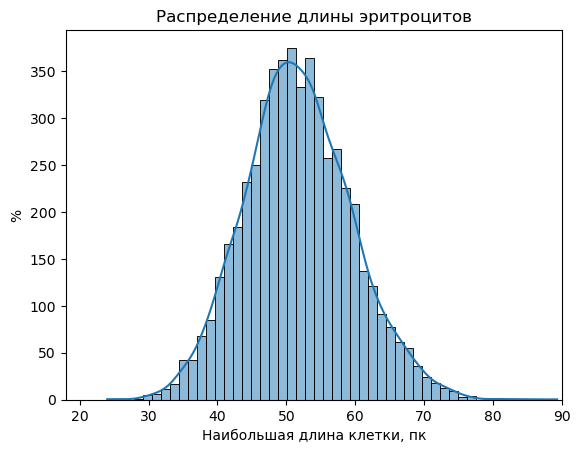

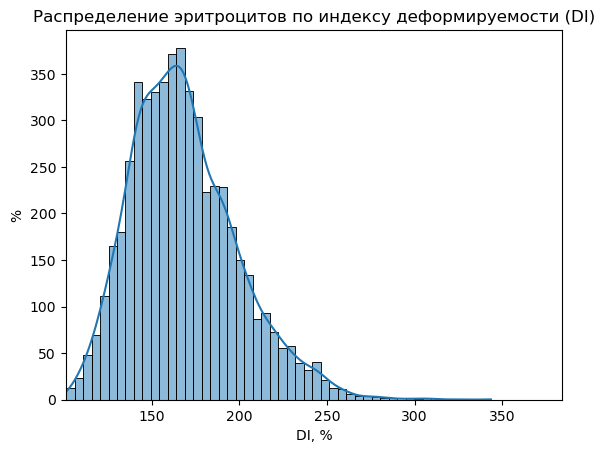

Обработано 33 изображений
Всего клеток на изображениях:  5285


In [9]:
human_cells_count = 0 # количество клеток на всех изображениях
areas = []
lengths = []
widths = []
DI = []

for npy_file in tqdm(npy_files):    
    # чтение масок
    npy_data = np.load(npy_file, allow_pickle=True).item()
    masks = npy_data['masks']
    human_cells_count += masks.max()

    # нахождение контуров
    for i in range(1, masks.max()+1):
        mask = masks.copy()
        mask[mask != i] = 0
        mask[mask == i] = 1
        mask = np.array(mask, np.uint8)
        contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
        cnt = contour[0]
        areas.append(area_of_rbc(cnt))
        lengths.append(length_of_rbc(cnt))
        widths.append(width_of_rbc(cnt))
        DI.append(lengths[-1]/widths[-1]*100)

# Распределение по площадям
bins = 50
sns.histplot(areas, bins=bins, kde=True)
plt.title('Распределение площадей эритроцитов')
plt.xlabel('Площадь, пкс^2')
plt.ylabel('%')
plt.xlim(area_limits)
plt.show()

# Распределение по длинам
sns.histplot(lengths, bins=bins, kde=True)
plt.title('Распределение длины эритроцитов')
plt.xlabel('Наибольшая длина клетки, пк')
plt.ylabel('%')
plt.xlim(length_limits)
plt.show()

# Распределение по DI
sns.histplot(DI, bins=bins, kde=True)
plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
plt.xlabel('DI, %')
plt.ylabel('%')
plt.xlim(DI_limits)
plt.show()

print(f"Обработано {len(npy_files)} изображений")
print('Всего клеток на изображениях: ', human_cells_count)

In [254]:
print("Диапазон (areas): ", round(min(areas)), "-", round(max(areas)))
print("Диапазон (lengths): ", round(min(lengths)), "-", round(max(lengths)))
print("Диапазон (DI): ", round(min(DI)), "-", round(max(DI)))

Диапазон (areas):  386 - 2244
Диапазон (lengths):  24 - 89
Диапазон (DI):  101 - 343


# Обработка с помощью Cellpose

## Пример гистограммы (DI, площадь, длина)

Количество клеток на изображении 182


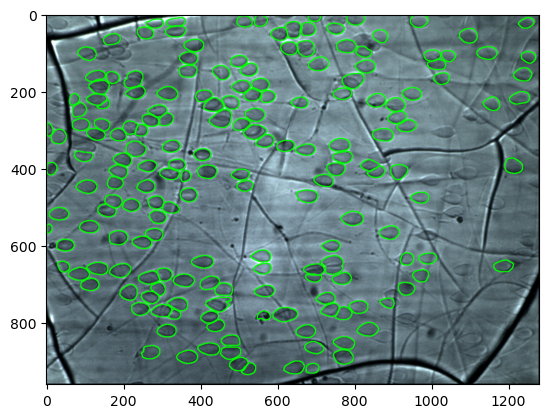

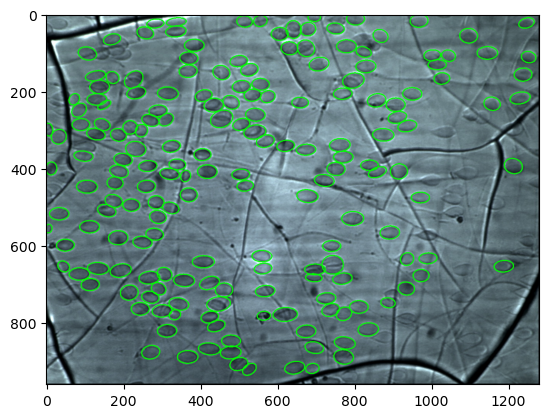

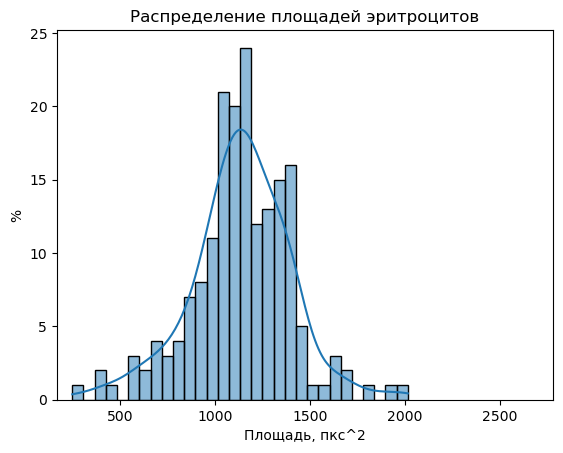

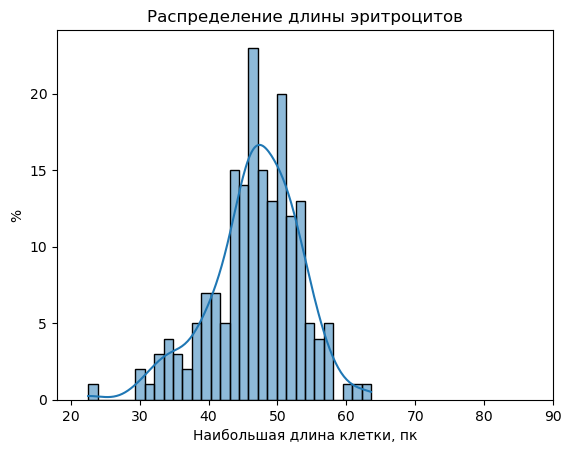

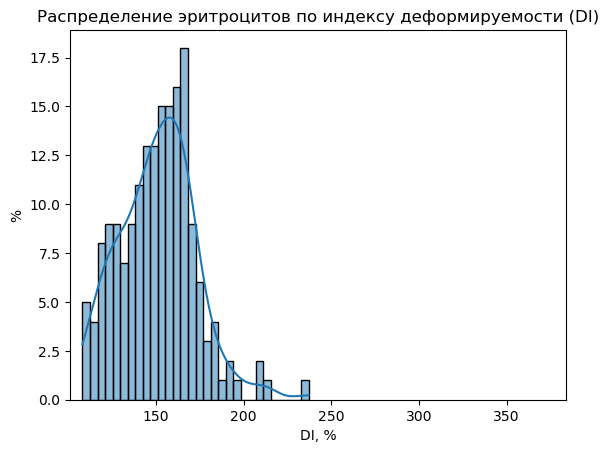

In [10]:
images_path = r'C:\Users\gorod\Desktop\2024-10-17'
cellpose_path = r'C:\Users\gorod\Desktop\2024-10-17\cellpose'
cellpose_masks_path = r'C:\Users\gorod\Desktop\2024-10-17\cellpose masks'

# чтение масок
masks = Image.open(r"C:\Users\gorod\Desktop\2024-10-17\cellpose masks\2024-10-17 15-36-43_2014_cp_masks.png")
masks = np.asarray(masks)
print("Количество клеток на изображении", masks.max())

# нахождение контуров
image_file = r'C:\Users\gorod\Desktop\2024-10-17\2024-10-17 15-36-43_2014.jpg'
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
contours = []
areas = []
lengths = []
widths = []
DI = []
for i in range(1, masks.max()+1):
    mask = masks.copy()
    mask[mask != i] = 0
    mask[mask == i] = 1
    mask = np.array(mask, np.uint8)
    contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
    cnt = contour[0]
    contours.append(cnt)
    areas.append(area_of_rbc(cnt))
    lengths.append(length_of_rbc(cnt))
    widths.append(width_of_rbc(cnt))
    DI.append(lengths[-1]/widths[-1]*100)
image_with_countours = image.copy() # чтобы не менять оригинал
image_with_countours = cv2.drawContours(image_with_countours, contours, -1, (0,255,0), 2)
plt.imshow(image_with_countours)
plt.show()

# отображение эллипсов
ellipses = []
image_with_ellipses = image.copy() # чтобы не менять оригинал
for cnt in contours:
    # rect = cv2.minAreaRect(cnt)
    ellipse = cv2.fitEllipse(cnt)
    ellipses.append(ellipse)
    # draw_min_area_rect(image_with_rects, ellipse)
    cv2.ellipse(image_with_ellipses, ellipse, (0, 255, 0), 2)
plt.imshow(image_with_ellipses)
plt.show()

# Распределение по площадям
bins = 30
sns.histplot(areas, bins=bins, kde=True)
plt.title('Распределение площадей эритроцитов')
plt.xlabel('Площадь, пкс^2')
plt.ylabel('%')
plt.xlim(area_limits)
plt.show()

# Распределение по длинам
sns.histplot(lengths, bins=bins, kde=True)
plt.title('Распределение длины эритроцитов')
plt.xlabel('Наибольшая длина клетки, пк')
plt.ylabel('%')
plt.xlim(length_limits)
plt.show()

# Распределение по DI
sns.histplot(DI, bins=bins, kde=True)
plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
plt.xlabel('DI, %')
plt.ylabel('%')
plt.xlim(DI_limits)
plt.show()

## Сохранение гистограммы для каждого изображения

In [128]:
cellpose_masks_files = [os.path.join(cellpose_masks_path, file) for file in os.listdir(cellpose_masks_path) if "_cp_masks.png" in file]

In [129]:
human_cells_count = 0 # количество клеток на всех изображениях

for cellpose_mask_file in tqdm(cellpose_masks_files):
    image_filename = os.path.basename(cellpose_mask_file)[:-13] # имя файла без расширения
    
    # чтение масок
    masks = Image.open(cellpose_mask_file)
    masks = np.asarray(masks)
    human_cells_count += masks.max()
    
    # нахождение контуров
    image_path = os.path.join(images_path, image_filename + ".jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    contours = []
    areas = []
    lengths = []
    widths = []
    DI = []
    for i in range(1, masks.max()+1):
        mask = masks.copy()
        mask[mask != i] = 0
        mask[mask == i] = 1
        mask = np.array(mask, np.uint8)
        contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
        cnt = contour[0]
        contours.append(cnt)
        try:
            ellipse = cv2.fitEllipse(cnt) # проверка, достаточно ли точек
        except Exception:
            continue
        areas.append(area_of_rbc(cnt))
        lengths.append(length_of_rbc(cnt))
        widths.append(width_of_rbc(cnt))
        DI.append(lengths[-1]/widths[-1]*100)
    image_with_countours = cv2.drawContours(image, contours, -1, (0,255,0), 2)
    plt.imshow(image_with_countours)
    plt.savefig(os.path.join(cellpose_path, image_filename + f"_1_countours ({masks.max()}).png"))
    plt.clf()

    # Распределение по площадям
    bins = 30
    sns.histplot(areas, bins=bins, kde=True)
    plt.title('Распределение площадей эритроцитов')
    plt.xlabel('Площадь, пкс^2')
    plt.ylabel('%')
    plt.xlim(area_limits)
    plt.savefig(os.path.join(cellpose_path, image_filename + "_2_areas.png"))
    plt.clf()

    # Распределение по длинам
    sns.histplot(lengths, bins=bins, kde=True)
    plt.title('Распределение длины эритроцитов')
    plt.xlabel('Наибольшая длина клетки, пк')
    plt.ylabel('%')
    plt.xlim(length_limits)
    plt.savefig(os.path.join(cellpose_path, image_filename + "_3_lengths.png"))
    plt.clf()

    # Распределение по DI
    sns.histplot(DI, bins=bins, kde=True)
    plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
    plt.xlabel('DI, %')
    plt.ylabel('%')
    plt.xlim(DI_limits)
    plt.savefig(os.path.join(cellpose_path, image_filename + "_4_DI.png"))
    plt.clf()
plt.close()

print(f"Обработано {len(cellpose_masks_files)} изображений")
print('Всего клеток на изображениях: ', human_cells_count)

100%|██████████| 33/33 [02:14<00:00,  4.07s/it]

Обработано 33 изображений
Всего клеток на изображениях:  5453


## Гистограмма по всем изображениям

100%|██████████| 33/33 [01:08<00:00,  2.08s/it]


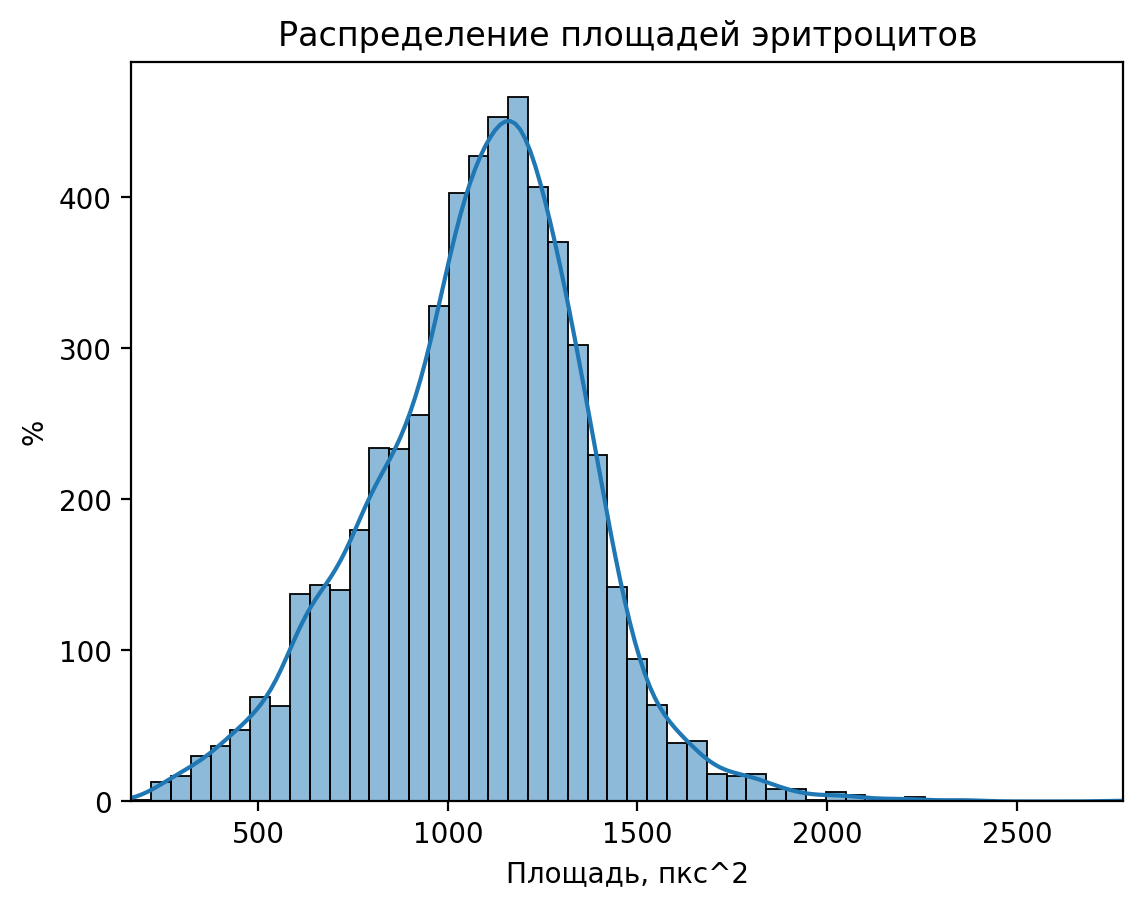

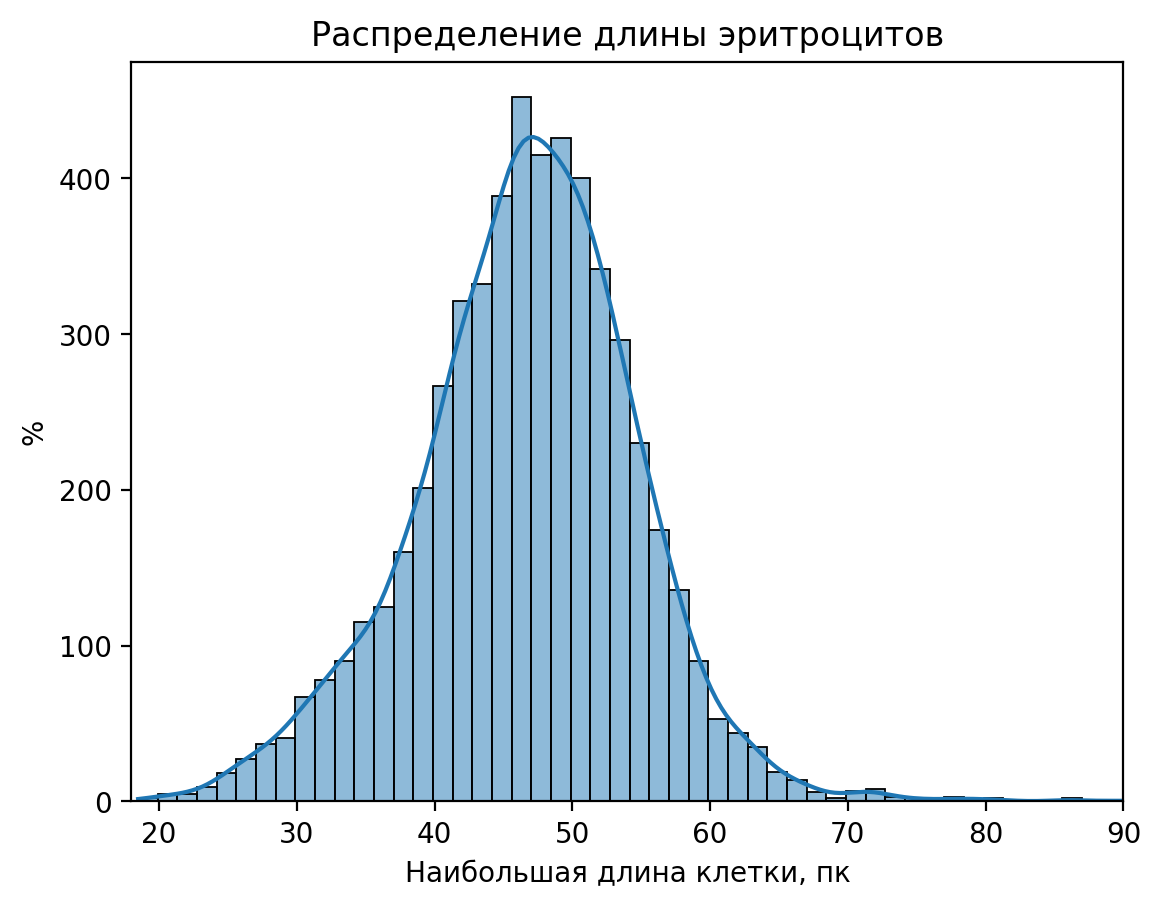

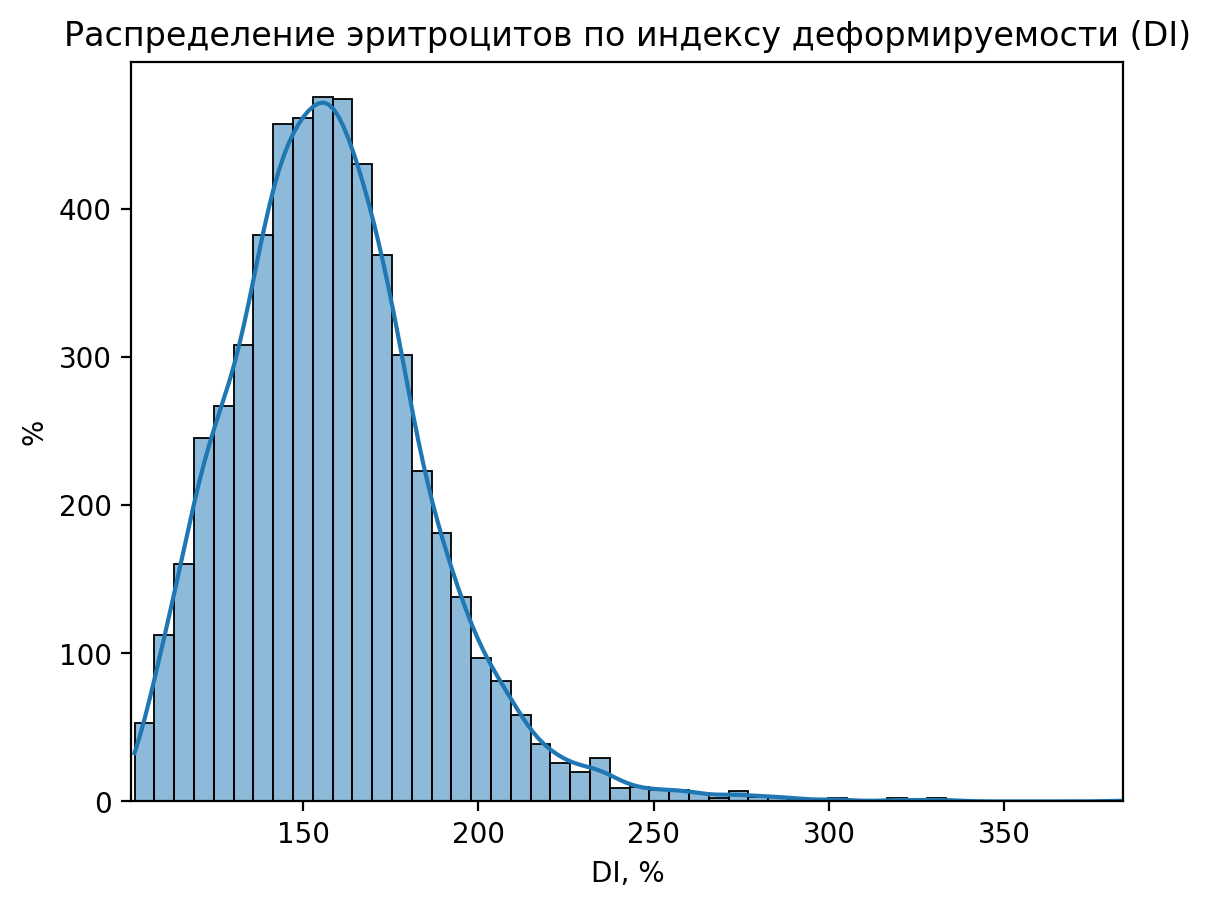

Обработано 33 изображений
Всего клеток на изображениях:  5453


In [130]:
human_cells_count = 0 # количество клеток на всех изображениях
areas = []
lengths = []
widths = []
DI = []

for cellpose_mask_file in tqdm(cellpose_masks_files):
    image_filename = os.path.basename(cellpose_mask_file)[:-13] # имя файла без расширения
    
    # чтение масок
    masks = Image.open(cellpose_mask_file)
    masks = np.asarray(masks)
    human_cells_count += masks.max()
    
    # нахождение контуров
    for i in range(1, masks.max()+1):
        mask = masks.copy()
        mask[mask != i] = 0
        mask[mask == i] = 1
        mask = np.array(mask, np.uint8)
        contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
        cnt = contour[0]
        try:
            ellipse = cv2.fitEllipse(cnt) # проверка, достаточно ли точек
        except Exception:
            continue
        areas.append(area_of_rbc(cnt))
        lengths.append(length_of_rbc(cnt))
        widths.append(width_of_rbc(cnt))
        DI.append(lengths[-1]/widths[-1]*100)

# Распределение по площадям
bins = 50
sns.histplot(areas, bins=bins, kde=True)
plt.title('Распределение площадей эритроцитов')
plt.xlabel('Площадь, пкс^2')
plt.ylabel('%')
plt.xlim(area_limits)
plt.show()

# Распределение по длинам
sns.histplot(lengths, bins=bins, kde=True)
plt.title('Распределение длины эритроцитов')
plt.xlabel('Наибольшая длина клетки, пк')
plt.ylabel('%')
plt.xlim(length_limits)
plt.show()

# Распределение по DI
sns.histplot(DI, bins=bins, kde=True)
plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
plt.xlabel('DI, %')
plt.ylabel('%')
plt.xlim(DI_limits)
plt.show()

print(f"Обработано {len(npy_files)} изображений")
print('Всего клеток на изображениях: ', human_cells_count)

In [252]:
print("Диапазон (areas): ", round(min(areas)), "-", round(max(areas)))
print("Диапазон (lengths): ", round(min(lengths)), "-", round(max(lengths)))
print("Диапазон (DI): ", round(min(DI)), "-", round(max(DI)))

Диапазон (areas):  166 - 2781
Диапазон (lengths):  18 - 90
Диапазон (DI):  102 - 384


# Обработка с помощью Stardist

## Проверка работы

In [256]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'prediction + input overlay')

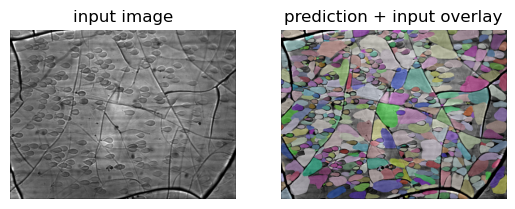

In [258]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

# img = test_image_nuclei_2d()
image_file = r'C:\Users\gorod\Desktop\2024-10-17\2024-10-17 15-36-43_2014.jpg'
img = cv2.imread(image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

labels, _ = model.predict_instances(normalize(img))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

## Подготовка датасета

In [ ]:
# def resize_img(img, scale=0.1):
#     width = int(img.shape[1] * scale)
#     height = int(img.shape[0] * scale)
#     dsize = (width, height)
#     img_res = cv2.resize(img, dsize)
#     return img_res

In [37]:
masks_path = r'C:\Users\gorod\Desktop\2024-10-17\cellpose masks'
npy_files = [os.path.join(images_path, file) for file in os.listdir(images_path) if ".npy" in file]

image_files = [os.path.join(images_path, file) for file in os.listdir(images_path) if ".jpg" in file]
tif_images_path = r'C:\Users\gorod\Desktop\2024-10-17\tif images'

# преобразовать все картинки в .tif
# for file_path in tqdm(image_files):
#     image = cv2.imread(file_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # crop_img = resize_img(image, scale=0.2)
#     filename = os.path.basename(file_path)[:-4]
#     cv2.imwrite(os.path.join(tif_images_path, filename) + '.tif', image)

In [60]:
def get_tiles(image):
    M = 256
    N = 256
    return [image[x-M:x,y-N:y] for x in range(M, image.shape[0], M) for y in range(N, image.shape[1], N)]

In [64]:
from random import random

dataset_train_images_path = r'C:\Users\gorod\Desktop\2024-10-17\stardist dataset\train\images'
dataset_test_images_path = r'C:\Users\gorod\Desktop\2024-10-17\stardist dataset\test\images'
dataset_train_masks_path = r'C:\Users\gorod\Desktop\2024-10-17\stardist dataset\train\masks'
dataset_test_masks_path = r'C:\Users\gorod\Desktop\2024-10-17\stardist dataset\test\masks'

# Разделение каждого изображения на 25 частей (20% на тестовую часть)
train_counter = 0
test_counter = 0
for i in trange(len(image_files)):
    image_file_path = image_files[i]
    image = cv2.imread(image_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    npy_file = npy_files[i]
    npy_data = np.load(npy_file, allow_pickle=True).item()
    masks = npy_data['masks']
    
    image_tiles = get_tiles(image)
    masks_tiles = get_tiles(masks)
    
    for i in range(len(image_tiles)):
        image_tile = image_tiles[i]
        masks_tile = masks_tiles[i]
        counter = 0
        for k in np.unique(masks_tile):
            masks_tile[masks_tile == k] = counter
            counter += 1
        if random() < 0.8:
            train_counter += 1
            image_filename = f'{train_counter}.tif'
            masks_filename = f'{train_counter}.tif'
            cv2.imwrite(os.path.join(dataset_train_images_path, image_filename), image_tile)
            cv2.imwrite(os.path.join(dataset_train_masks_path, masks_filename), masks_tile)
        else:
            test_counter += 1
            image_filename = f'{test_counter}.tif'
            masks_filename = f'{test_counter}.tif'
            cv2.imwrite(os.path.join(dataset_test_images_path, image_filename), image_tile)
            cv2.imwrite(os.path.join(dataset_test_masks_path, masks_filename), masks_tile)
print('Всего кусков в train: ', train_counter)
print('Всего кусков в test: ', test_counter)

  0%|          | 0/33 [00:00<?, ?it/s]

Всего кусков в train:  330
Всего кусков в test:  66


## Обучение

### Чтение датасета

In [12]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [67]:
X_trn = sorted(glob(dataset_train_images_path + '/*.tif'))
Y_trn = sorted(glob(dataset_train_masks_path + '/*.tif'))
X_val = sorted(glob(dataset_test_images_path + '/*.tif'))
Y_val = sorted(glob(dataset_test_masks_path + '/*.tif'))

assert all(Path(x).name==Path(y).name for x,y in zip(X_trn,Y_trn))
assert all(Path(x).name==Path(y).name for x,y in zip(X_val,Y_val))

In [68]:
X_trn = list(map(imread,X_trn))
Y_trn = list(map(imread,Y_trn))
X_val = list(map(imread,X_val))
Y_val = list(map(imread,Y_val))

n_channel = 1 if X_val[0].ndim == 2 else Y_val[0].shape[-1]
n_channel = 1 if X_trn[0].ndim == 2 else Y_trn[0].shape[-1]

In [69]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X_trn = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_trn)]
X_val = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_val)]

100%|██████████| 66/66 [00:00<00:00, 455.18it/s]


In [71]:
assert len(X_trn) > 1, "not enough training data"
assert len(X_val) > 1, "not enough val data"

rng = np.random.RandomState(42)
ind = rng.permutation(len(X_trn))
X_trn, Y_trn = [X_trn[i] for i in ind], [Y_trn[i] for i in ind] 

print('number of images: %3d' % (len(X_trn) + len(X_val)))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 396
- training:       330
- validation:      66


In [72]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

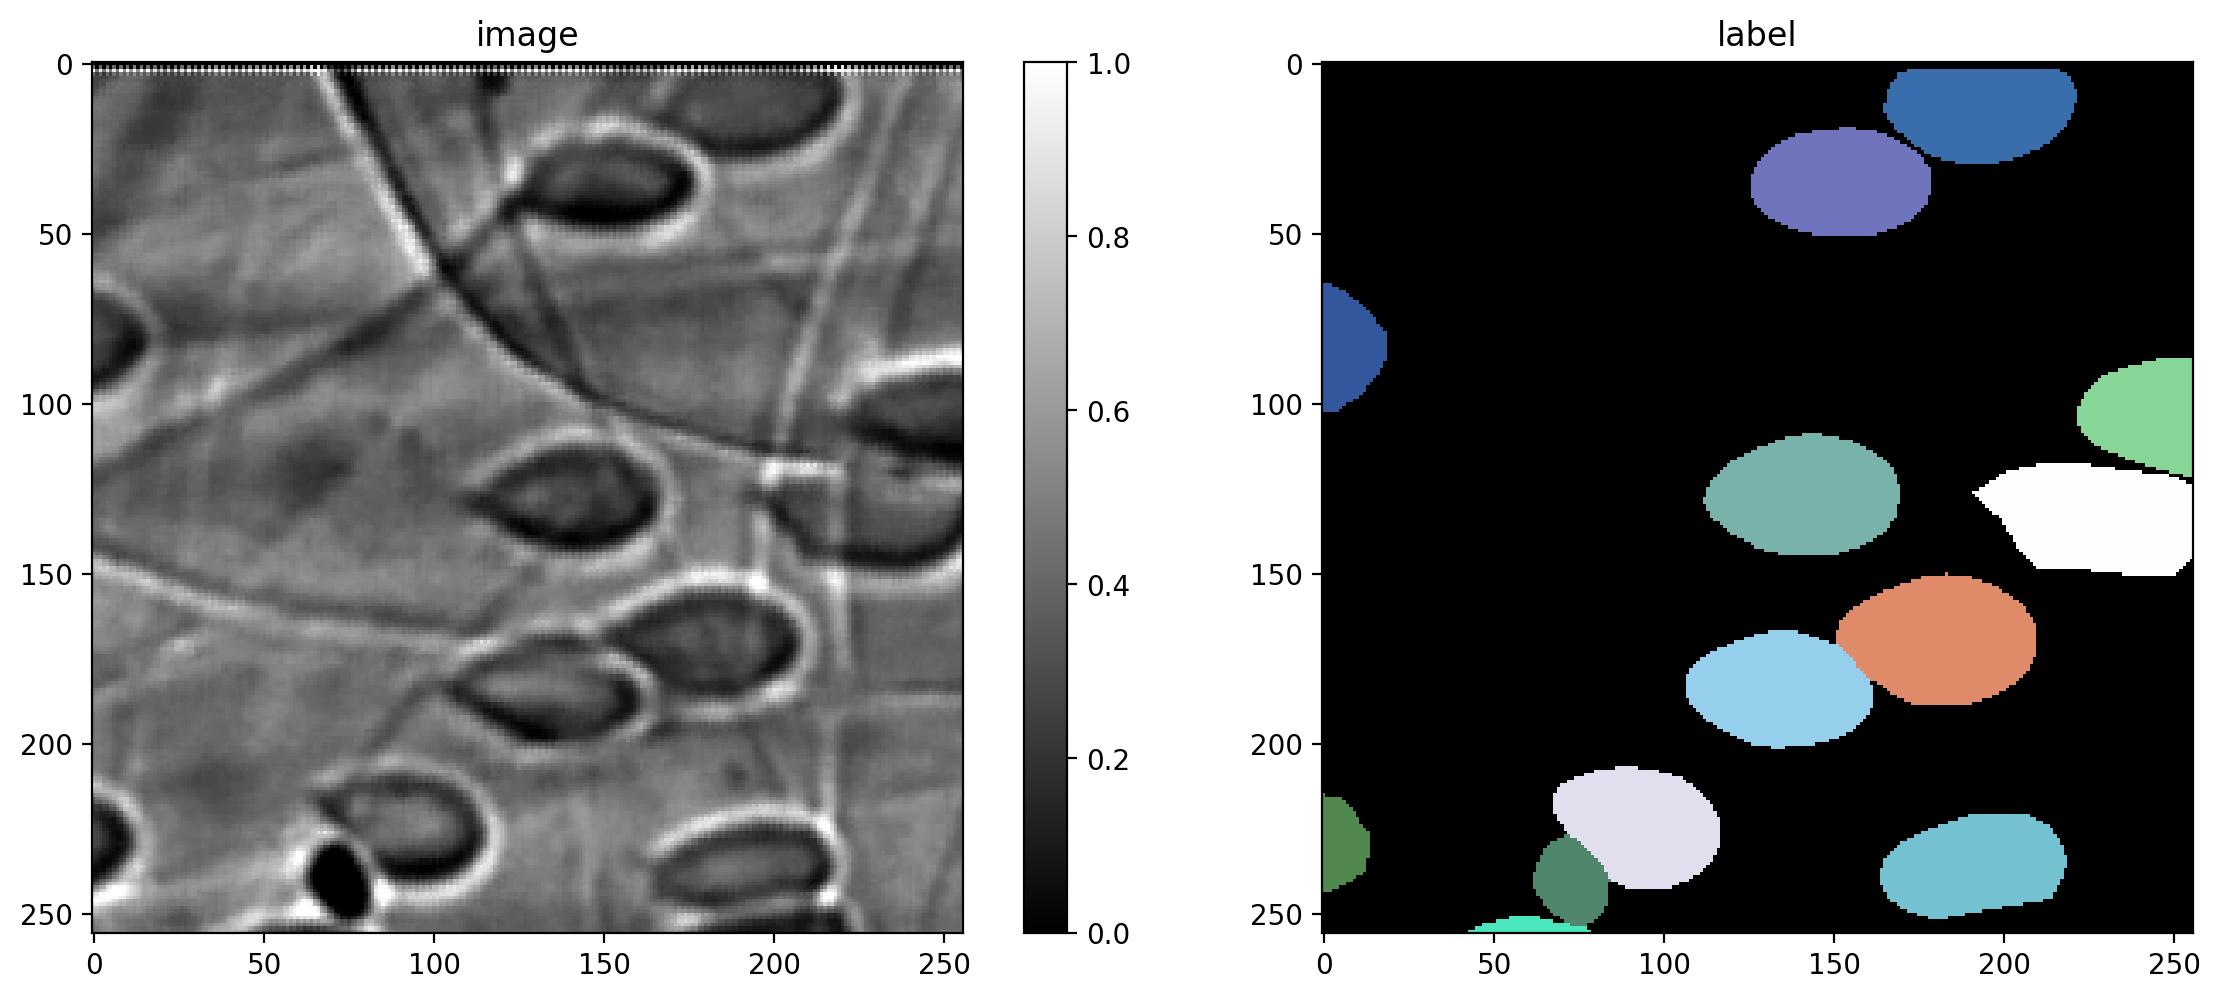

In [74]:
i = min(9, len(X_trn)-1)
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

In [76]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [77]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [79]:
model = StarDist2D(conf, name='stardist', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [80]:
median_size = calculate_extents(list(Y_trn), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [32. 49.]
network field of view :  [93 90]


### Data Augmentation

In [81]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

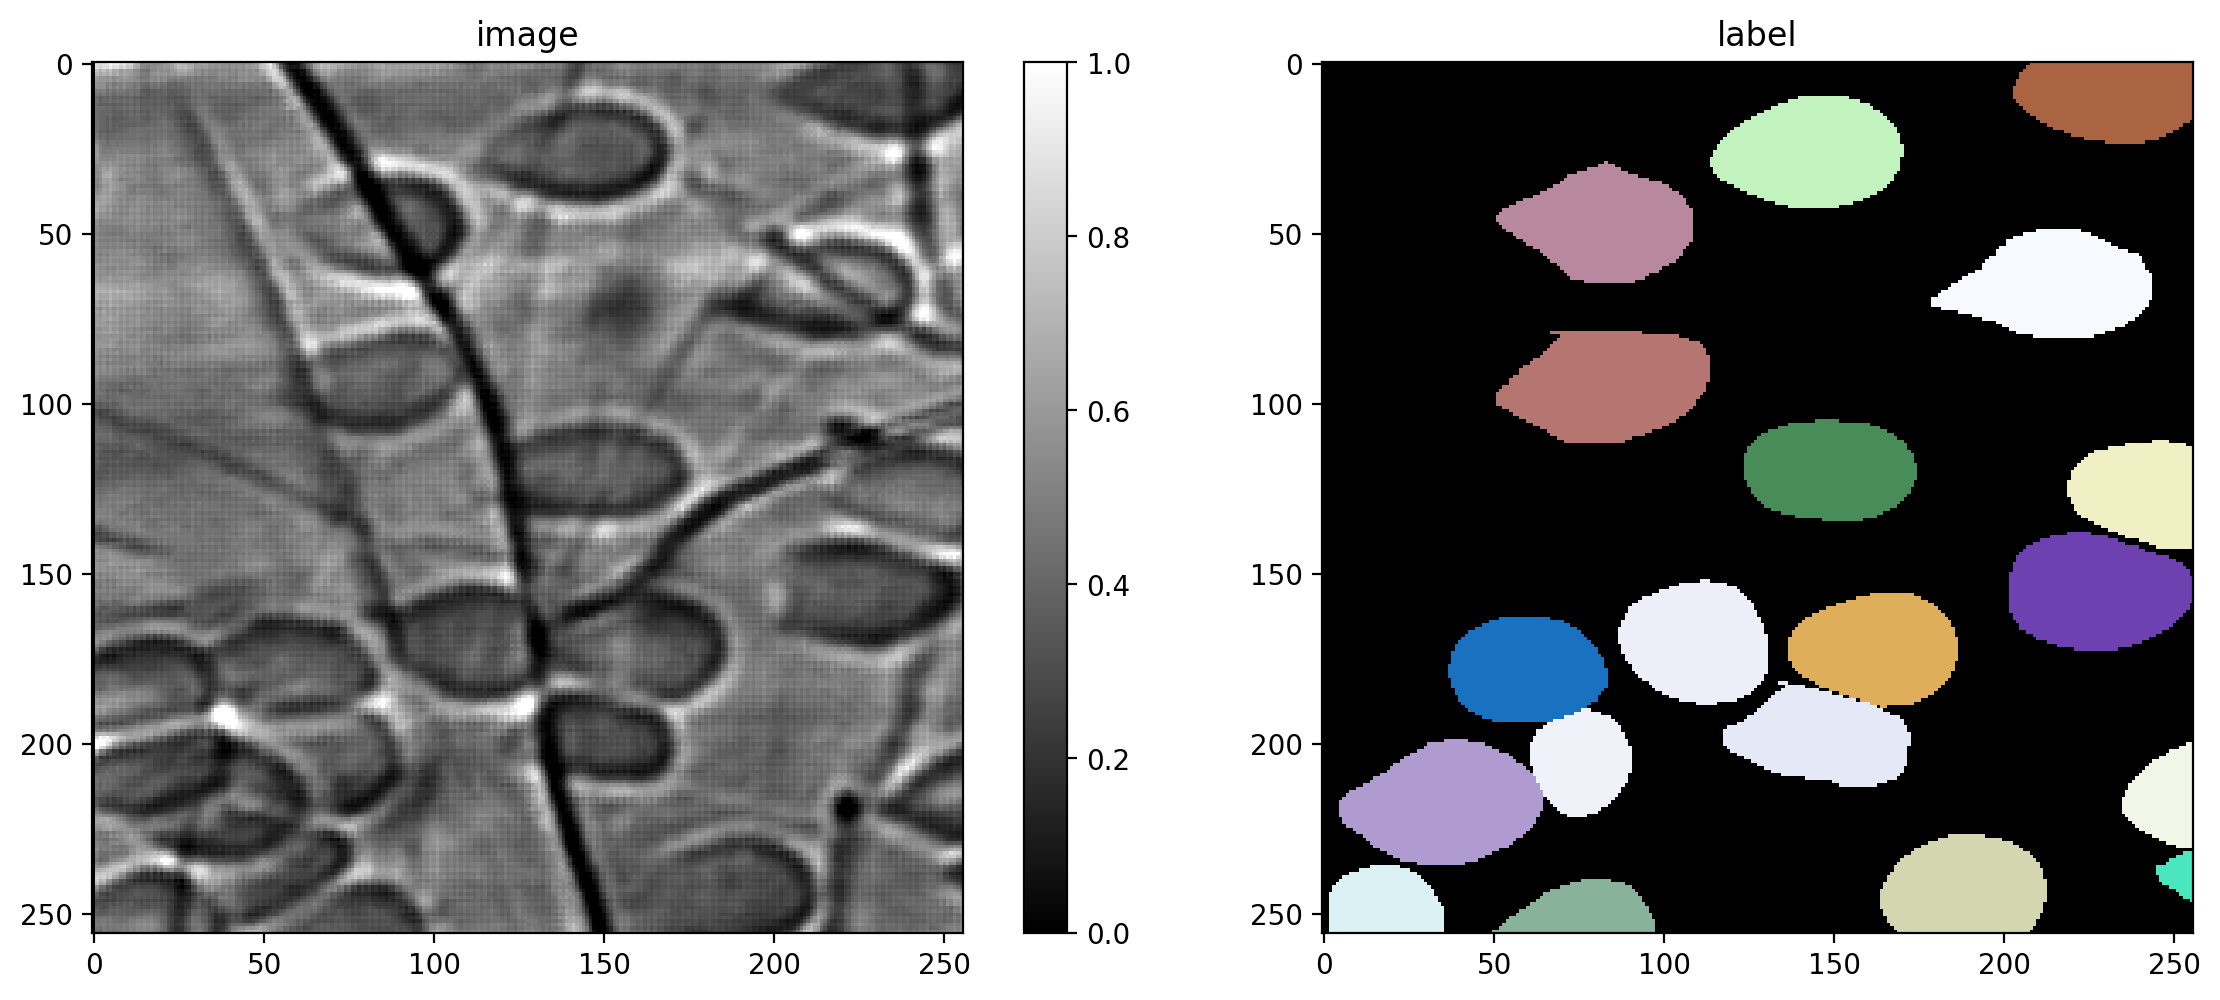

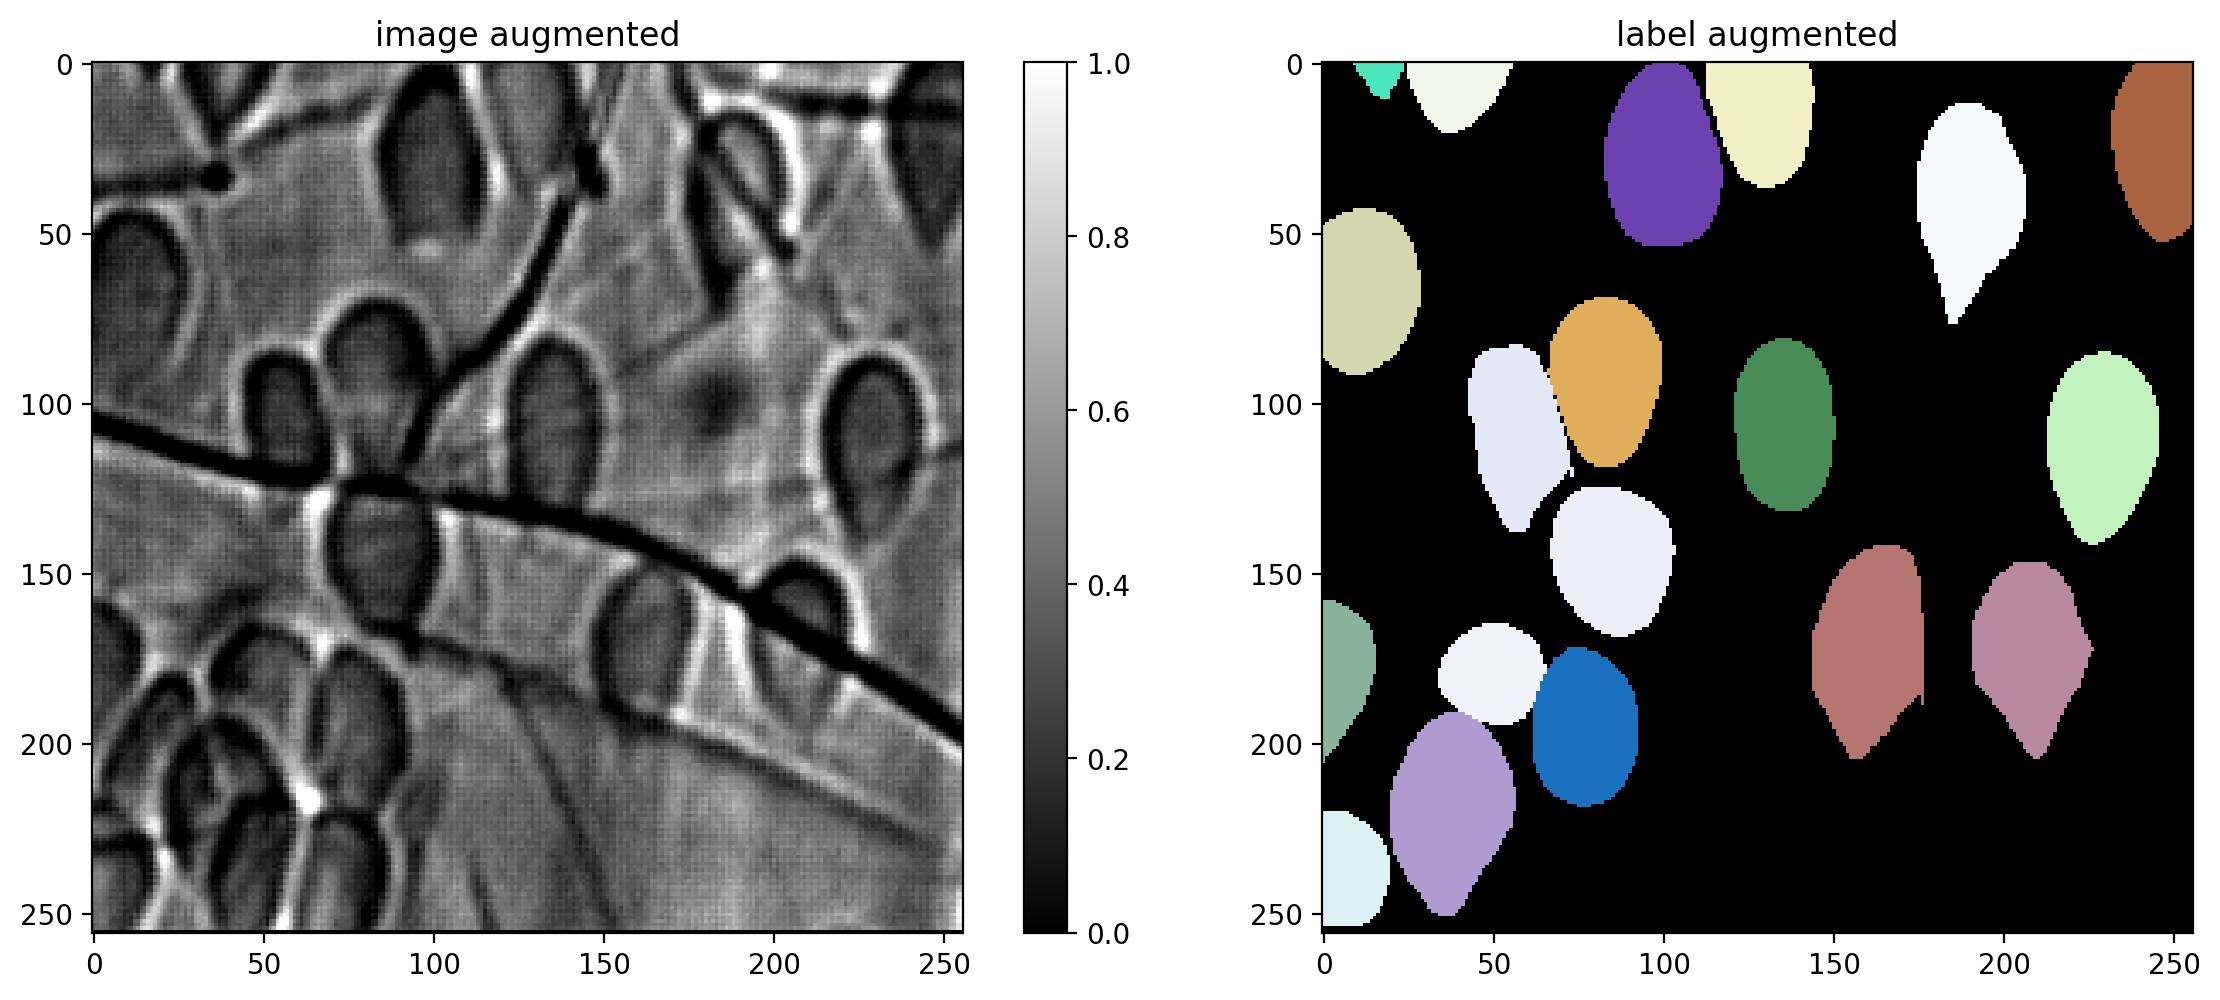

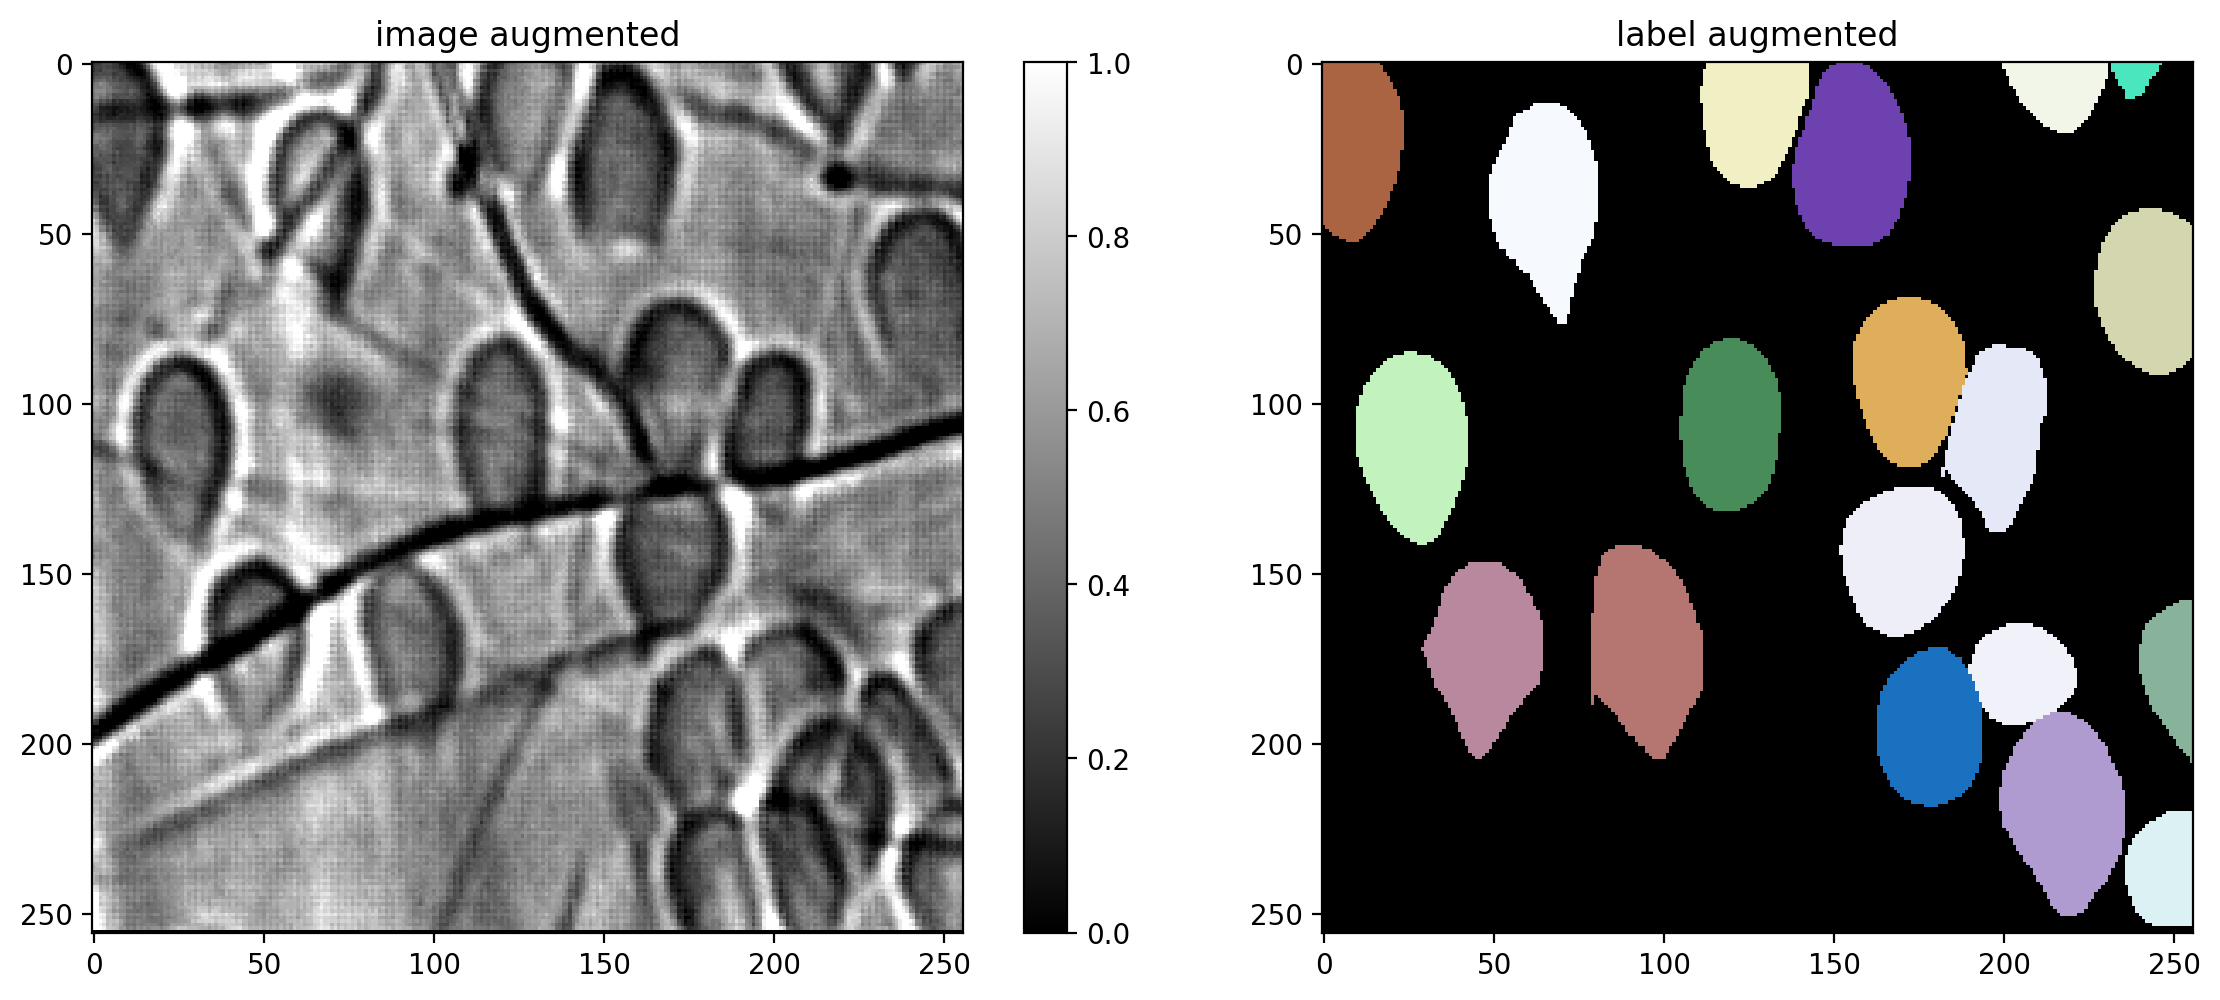

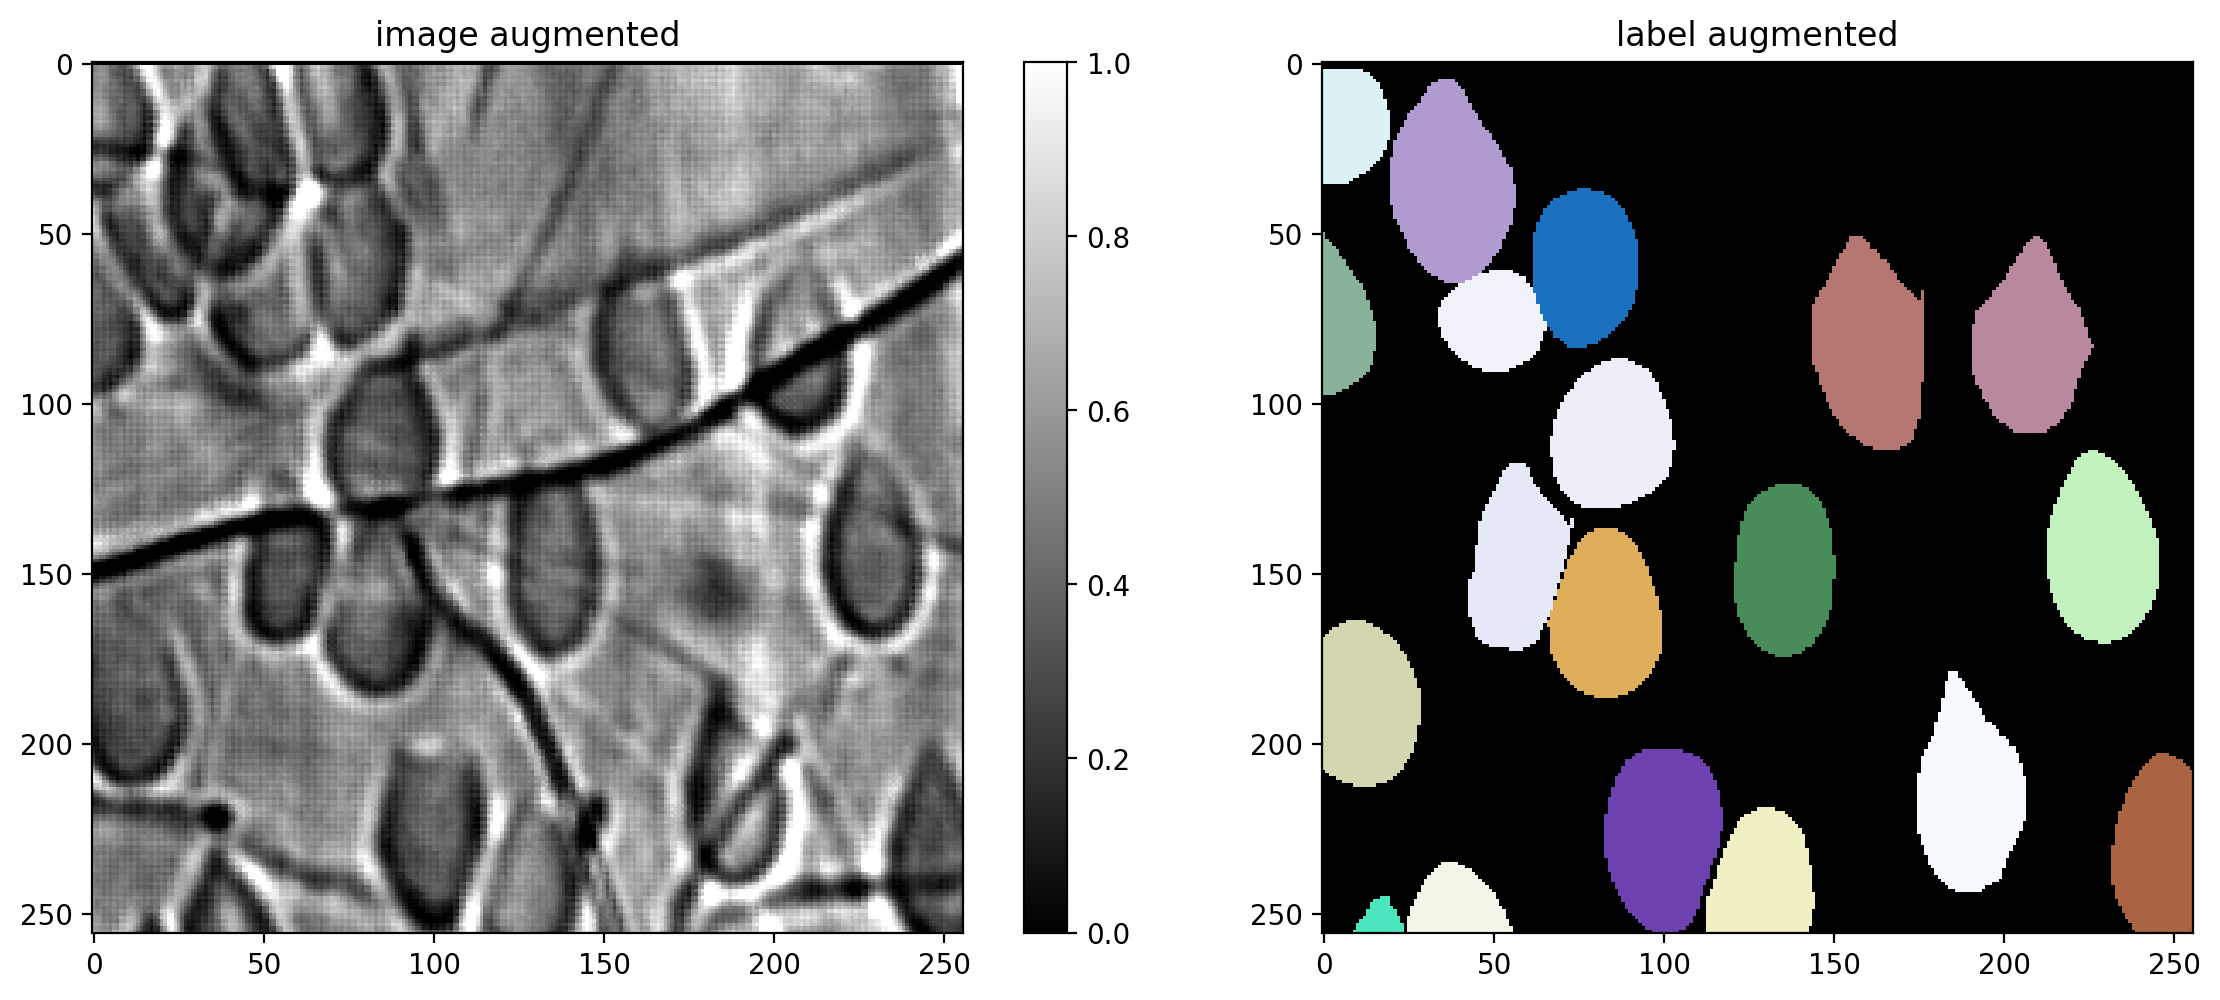

In [82]:
# plot some augmented examples
img, lbl = X_trn[0],Y_trn[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

### Training

In [88]:
# tensorboard --logdir=tensorboard_logs

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (1527640753.py, line 1)

In [89]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - dist_dist_iou_metric: 0.0633 - dist_loss: 3.0412 - dist_relevant_mae: 15.2056 - dist_relevant_mse: 329.2829 - loss: 3.4912 - prob_kld: 0.3483 - prob_loss: 0.4501 - val_dist_dist_iou_metric: 0.2831 - val_dist_loss: 1.7094 - val_dist_relevant_mae: 8.5474 - val_dist_relevant_mse: 127.1611 - val_loss: 2.0087 - val_prob_kld: 0.2121 - val_prob_loss: 0.2998 - learning_rate: 3.0000e-04
Epoch 2/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - dist_dist_iou_metric: 0.3794 - dist_loss: 1.6000 - dist_relevant_mae: 7.9984 - dist_relevant_mse: 107.3432 - loss: 1.8888 - prob_kld: 0.1949 - prob_loss: 0.2889 - val_dist_dist_iou_metric: 0.3762 - val_dist_loss: 1.5423 - val_dist_relevant_mae: 7.7074 - val_dist_relevant_mse: 102.0347 - val_loss: 1.7920 - val_prob_kld: 0.1641 - val_prob_loss: 0.2518 - learning_rate: 3.0000e-04
Epoch 3/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - dist_dist_iou_metric: 0.4057 - dist_loss: 1.5284 - dist_relevant_mae: 7

KeyboardInterrupt: 

In [92]:
model = StarDist2D(None, name='stardist', basedir='models')

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [93]:
model

StarDist2D(stardist): YXC → YXC
├─ Directory: C:\Users\gorod\Desktop\2024-10-17\notebook\models\stardist
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=[1, 1], train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n

In [94]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:39<00:09,  2.49s/it, 0.495 -> 0.767]


Using optimized values: prob_thresh=0.494957, nms_thresh=0.3.
Saving to 'thresholds.json'.


### Evaluation and Detection Performance

In [95]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 66/66 [00:31<00:00,  2.10it/s]


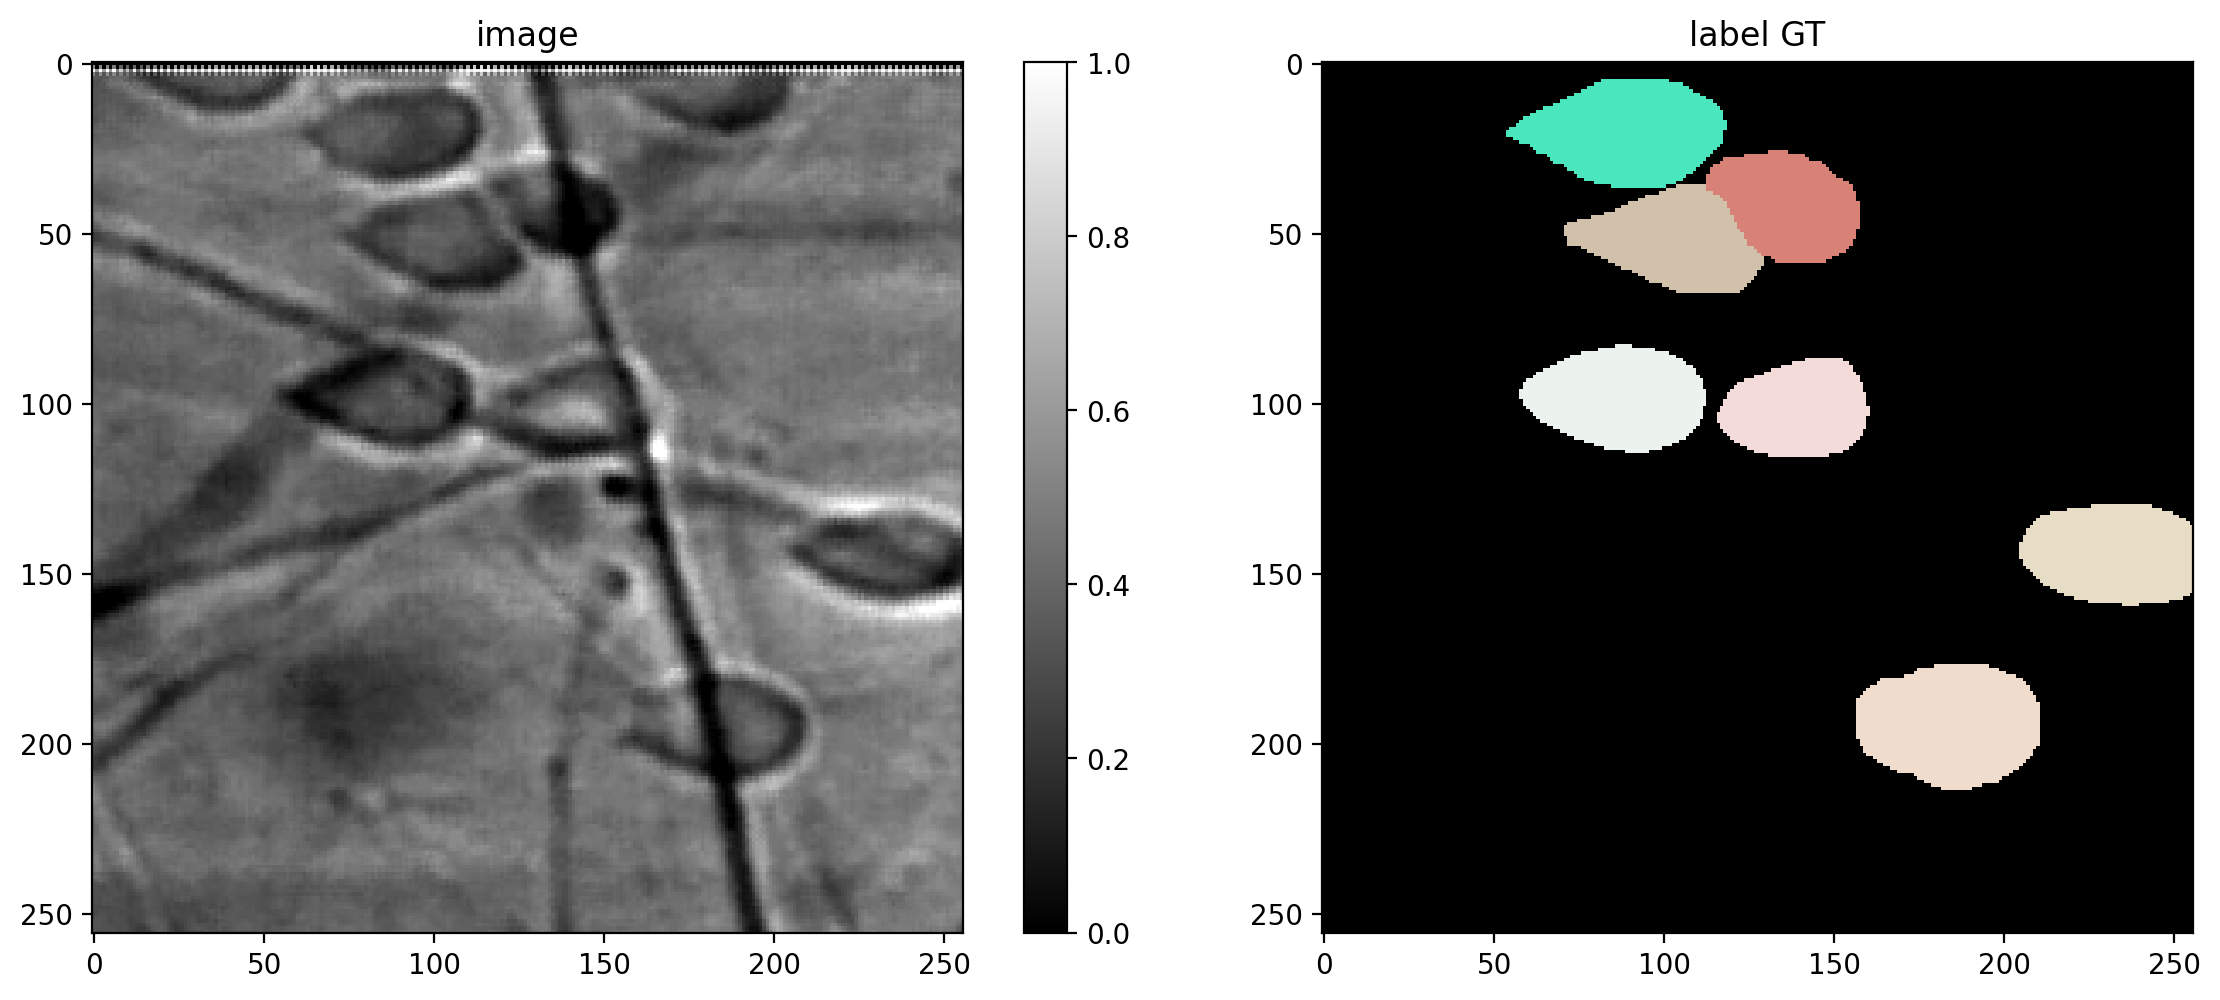

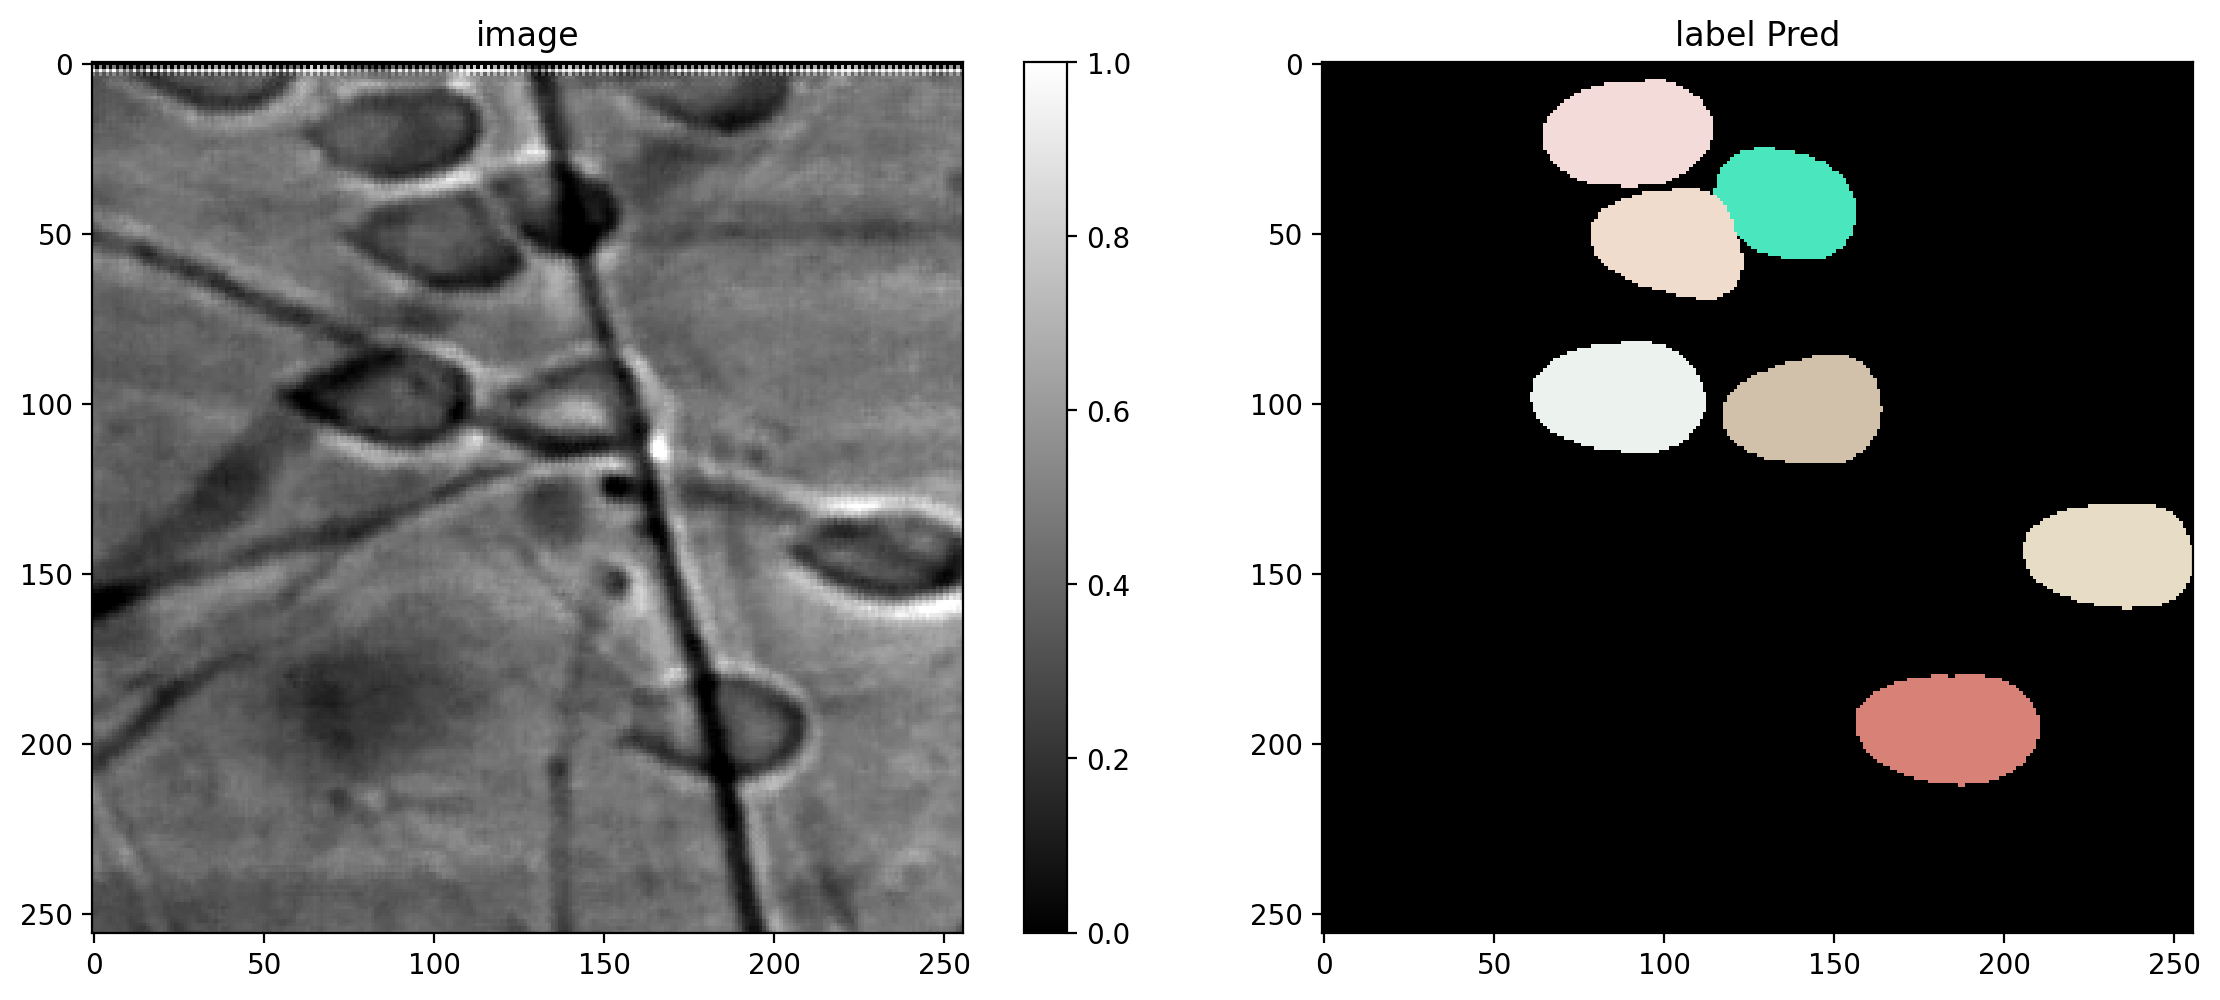

In [96]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

In [97]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


In [98]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=49, tp=581, fn=99, precision=0.9222222222222223, recall=0.8544117647058823, accuracy=0.7969821673525377, f1=0.8870229007633588, n_true=680, n_pred=630, mean_true_score=0.725084927064531, mean_matched_score=0.8486364034490208, panoptic_quality=0.7527599242807345, by_image=False)

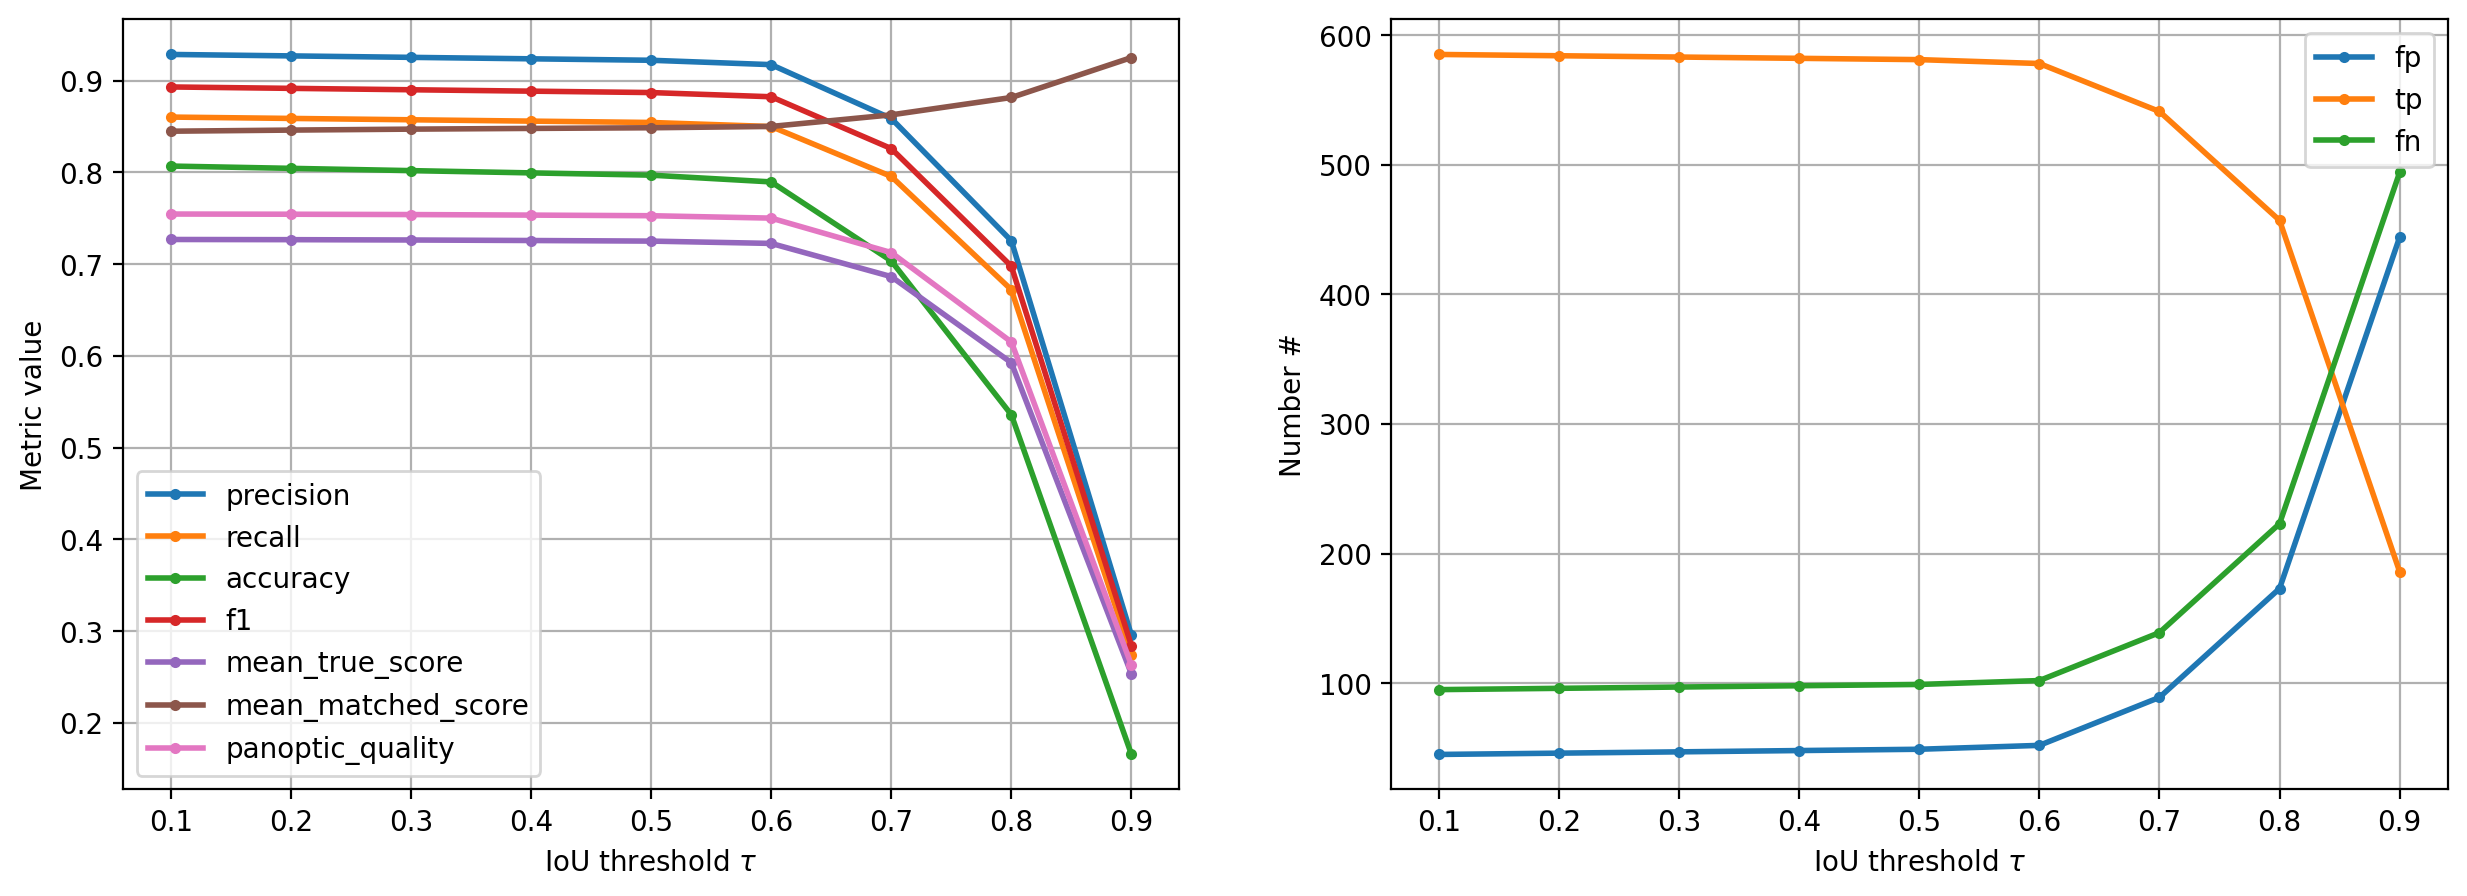

In [99]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

## Load trained model

In [14]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.494957, nms_thresh=0.3.


## Пример гистограммы (DI, площадь, длина)

100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Количество клеток на изображении 195


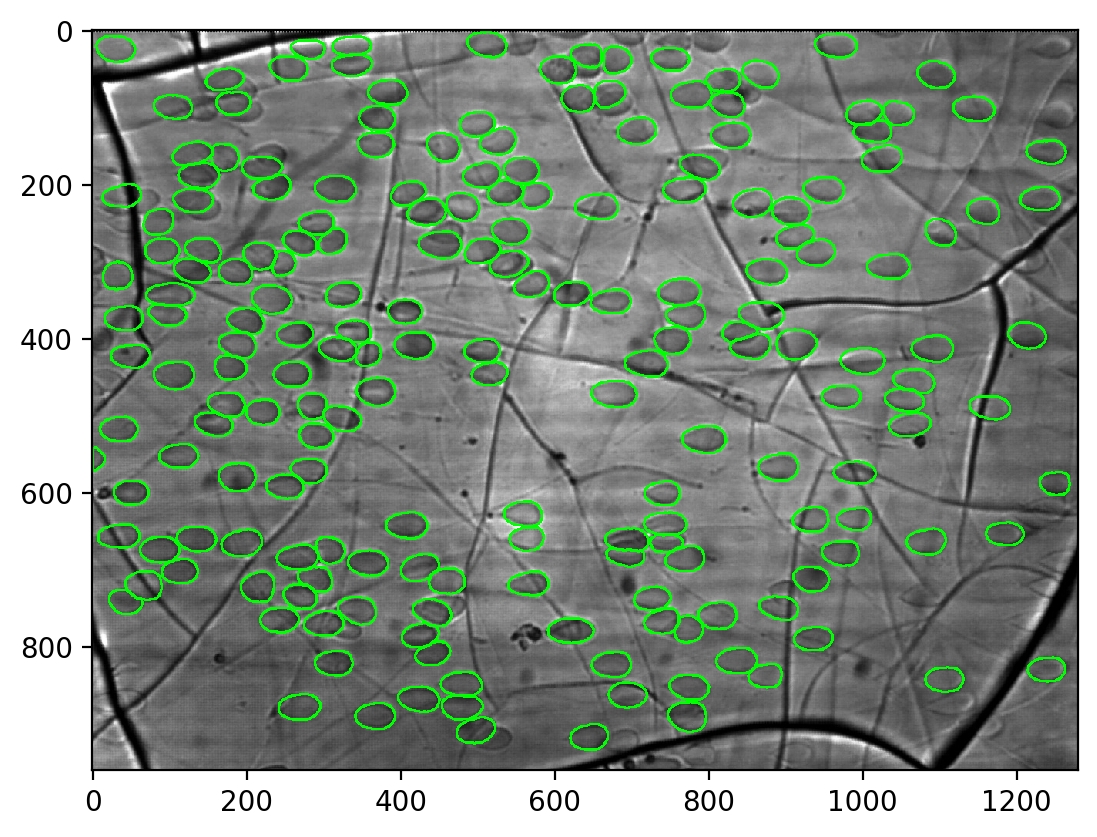

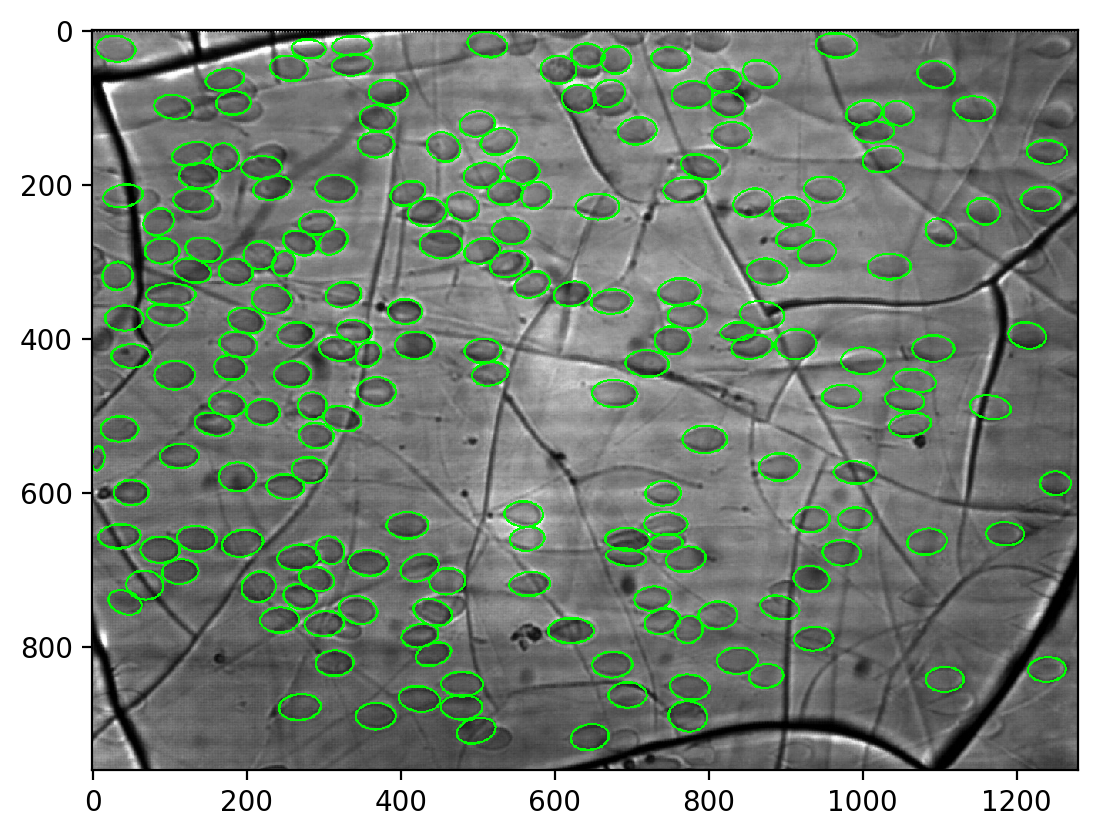

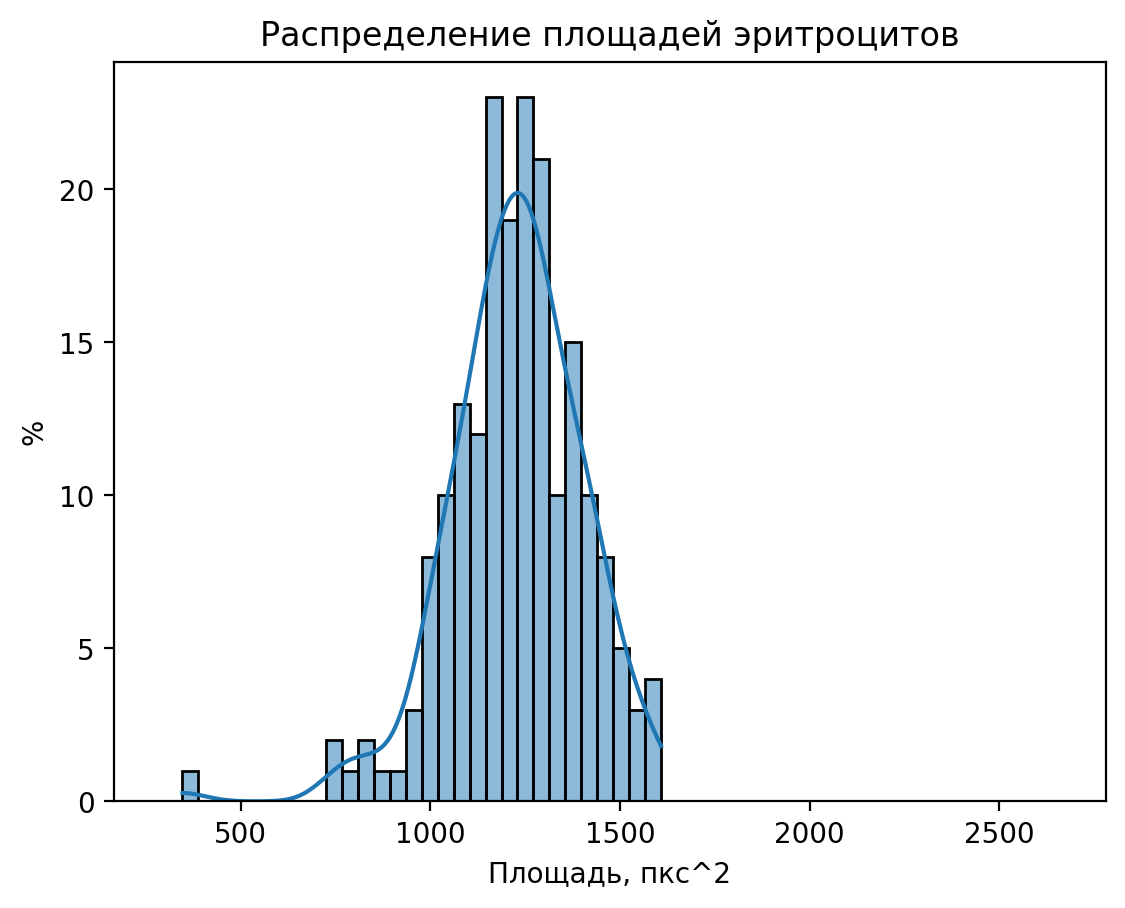

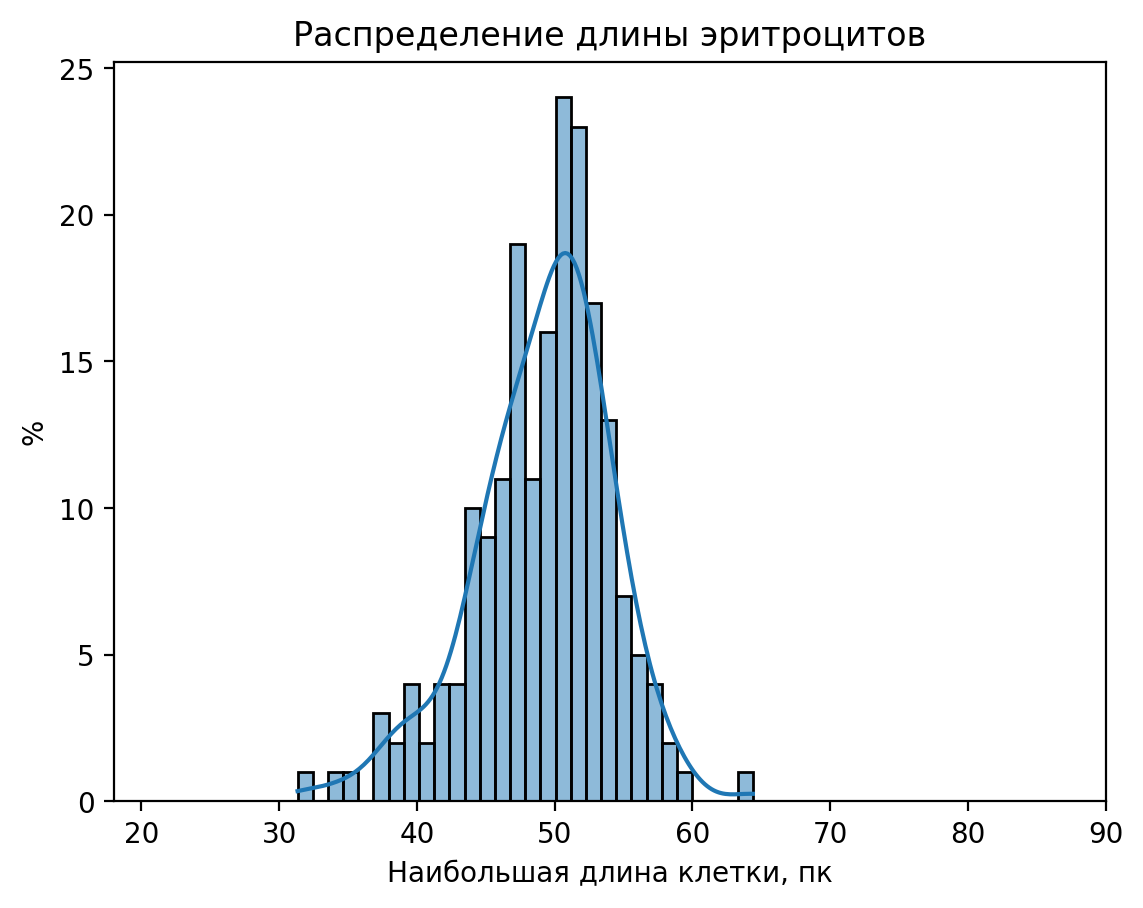

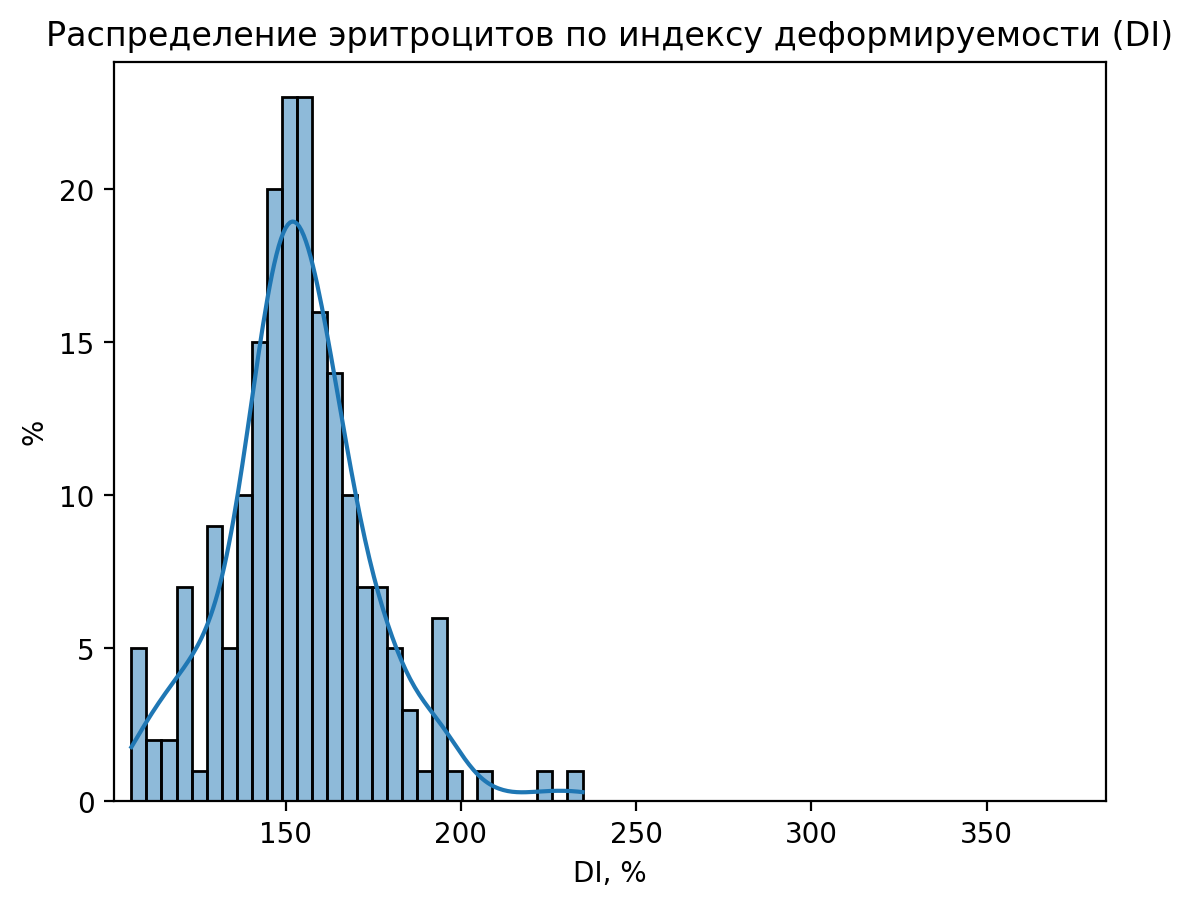

In [15]:
stardist_path = r'C:\Users\gorod\Desktop\2024-10-17\stardist'

# расчет масок
image_file = r'C:\Users\gorod\Desktop\2024-10-17\2024-10-17 15-36-43_2014.jpg'
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_normalized = normalize(image.copy())
masks, _ = model.predict_instances(image_normalized, n_tiles=model._guess_n_tiles(image_normalized), show_tile_progress=True)
print("Количество клеток на изображении", masks.max())

# нахождение контуров
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
contours = []
areas = []
lengths = []
widths = []
DI = []
for i in range(1, masks.max()+1):
    mask = masks.copy()
    mask[mask != i] = 0
    mask[mask == i] = 1
    mask = np.array(mask, np.uint8)
    contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
    cnt = contour[0]
    contours.append(cnt)
    areas.append(area_of_rbc(cnt))
    lengths.append(length_of_rbc(cnt))
    widths.append(width_of_rbc(cnt))
    DI.append(lengths[-1]/widths[-1]*100)
image_with_countours = image.copy() # чтобы не менять оригинал
image_with_countours = cv2.drawContours(image_with_countours, contours, -1, (0,255,0), 2)
plt.imshow(image_with_countours)
plt.show()

# отображение эллипсов
ellipses = []
image_with_ellipses = image.copy() # чтобы не менять оригинал
for cnt in contours:
    # rect = cv2.minAreaRect(cnt)
    ellipse = cv2.fitEllipse(cnt)
    ellipses.append(ellipse)
    # draw_min_area_rect(image_with_rects, ellipse)
    cv2.ellipse(image_with_ellipses, ellipse, (0, 255, 0), 2)
plt.imshow(image_with_ellipses)
plt.show()

# Распределение по площадям
bins = 30
sns.histplot(areas, bins=bins, kde=True)
plt.title('Распределение площадей эритроцитов')
plt.xlabel('Площадь, пкс^2')
plt.ylabel('%')
plt.xlim(area_limits)
plt.show()

# Распределение по длинам
sns.histplot(lengths, bins=bins, kde=True)
plt.title('Распределение длины эритроцитов')
plt.xlabel('Наибольшая длина клетки, пк')
plt.ylabel('%')
plt.xlim(length_limits)
plt.show()

# Распределение по DI
sns.histplot(DI, bins=bins, kde=True)
plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
plt.xlabel('DI, %')
plt.ylabel('%')
plt.xlim(DI_limits)
plt.show()

## Сохранение гистограммы для каждого изображения

In [103]:
# сначала сохраню маски для всех изображений

stardist_masks_path = r'C:\Users\gorod\Desktop\2024-10-17\stardist masks'
image_files = [os.path.join(images_path, file) for file in os.listdir(images_path) if ".jpg" in file]

for image_file in tqdm(image_files):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_normalized = normalize(image)
    masks, _ = model.predict_instances(image_normalized, n_tiles=model._guess_n_tiles(image_normalized), show_tile_progress=False)
    image_filename = os.path.basename(image_file)[:-4]
    cv2.imwrite(os.path.join(stardist_masks_path, image_filename) + '.tif', masks)

100%|██████████| 33/33 [04:42<00:00,  8.55s/it]


In [105]:
# читаю пути всех масок изображений
stardist_masks_files = [os.path.join(stardist_masks_path, file) for file in os.listdir(stardist_masks_path) if ".tif" in file]

In [132]:
human_cells_count = 0 # количество клеток на всех изображениях

for stardist_masks_file in tqdm(stardist_masks_files):
    image_filename = os.path.basename(stardist_masks_file)[:-4] # имя файла без расширения
    
    # чтение масок
    masks = Image.open(stardist_masks_file)
    masks = np.asarray(masks)
    human_cells_count += masks.max()
    
    # нахождение контуров
    image_path = os.path.join(images_path, image_filename + ".jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    contours = []
    areas = []
    lengths = []
    widths = []
    DI = []
    for i in range(1, masks.max()+1):
        mask = masks.copy()
        mask[mask != i] = 0
        mask[mask == i] = 1
        mask = np.array(mask, np.uint8)
        contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
        cnt = contour[0]
        contours.append(cnt)
        try:
            ellipse = cv2.fitEllipse(cnt) # проверка, достаточно ли точек
        except Exception:
            continue
        areas.append(area_of_rbc(cnt))
        lengths.append(length_of_rbc(cnt))
        widths.append(width_of_rbc(cnt))
        DI.append(lengths[-1]/widths[-1]*100)
    image_with_countours = cv2.drawContours(image, contours, -1, (0,255,0), 2)
    plt.imshow(image_with_countours)
    plt.savefig(os.path.join(stardist_path, image_filename + f"_1_countours ({masks.max()}).png"))
    plt.clf()

    # Распределение по площадям
    bins = 30
    sns.histplot(areas, bins=bins, kde=True)
    plt.title('Распределение площадей эритроцитов')
    plt.xlabel('Площадь, пкс^2')
    plt.ylabel('%')
    plt.xlim(area_limits)
    plt.savefig(os.path.join(stardist_path, image_filename + "_2_areas.png"))
    plt.clf()

    # Распределение по длинам
    sns.histplot(lengths, bins=bins, kde=True)
    plt.title('Распределение длины эритроцитов')
    plt.xlabel('Наибольшая длина клетки, пк')
    plt.ylabel('%')
    plt.xlim(length_limits)
    plt.savefig(os.path.join(stardist_path, image_filename + "_3_lengths.png"))
    plt.clf()

    # Распределение по DI
    sns.histplot(DI, bins=bins, kde=True)
    plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
    plt.xlabel('DI, %')
    plt.ylabel('%')
    plt.xlim(DI_limits)
    plt.savefig(os.path.join(stardist_path, image_filename + "_4_DI.png"))
    plt.clf()
plt.close()

print(f"Обработано {len(stardist_masks_files)} изображений")
print('Всего клеток на изображениях: ', human_cells_count)

100%|██████████| 33/33 [02:10<00:00,  3.96s/it]

Обработано 33 изображений
Всего клеток на изображениях:  5478


## Гистограмма по всем изображениям

100%|██████████| 33/33 [01:06<00:00,  2.02s/it]


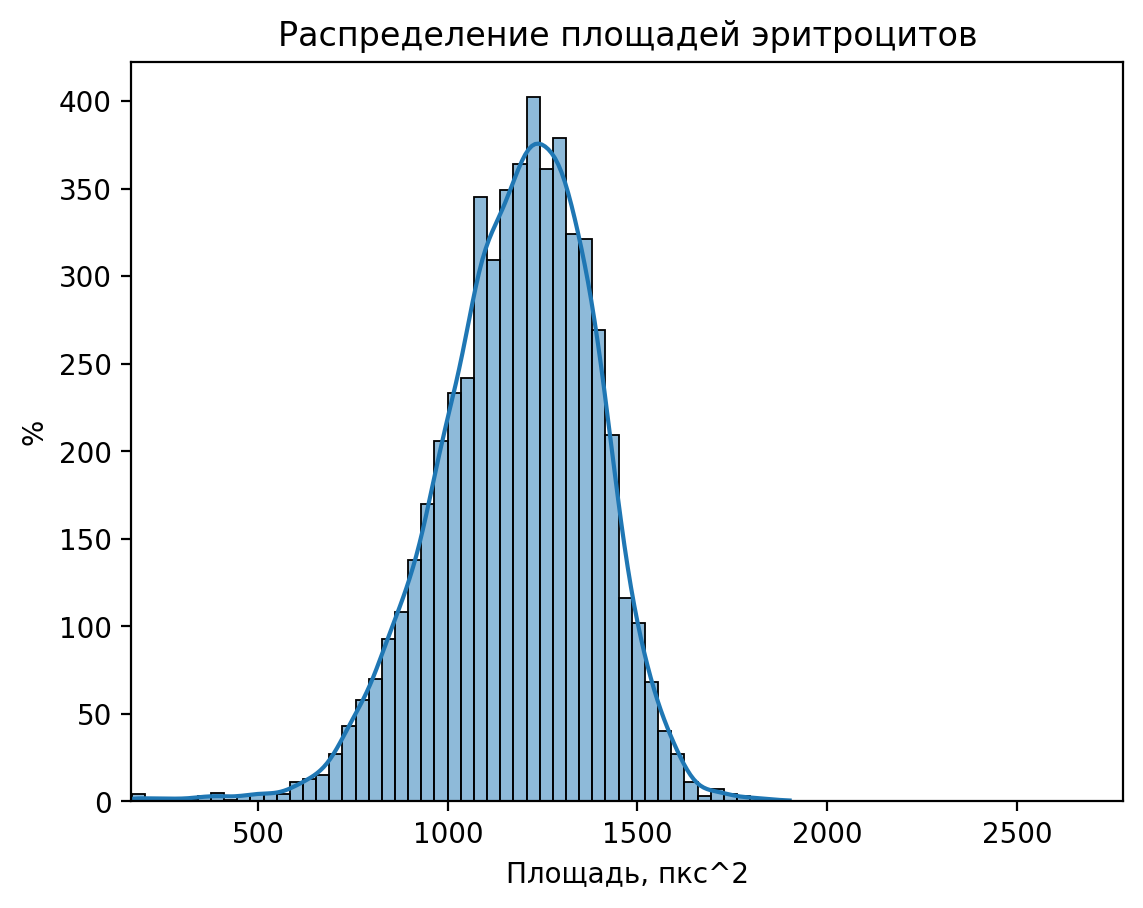

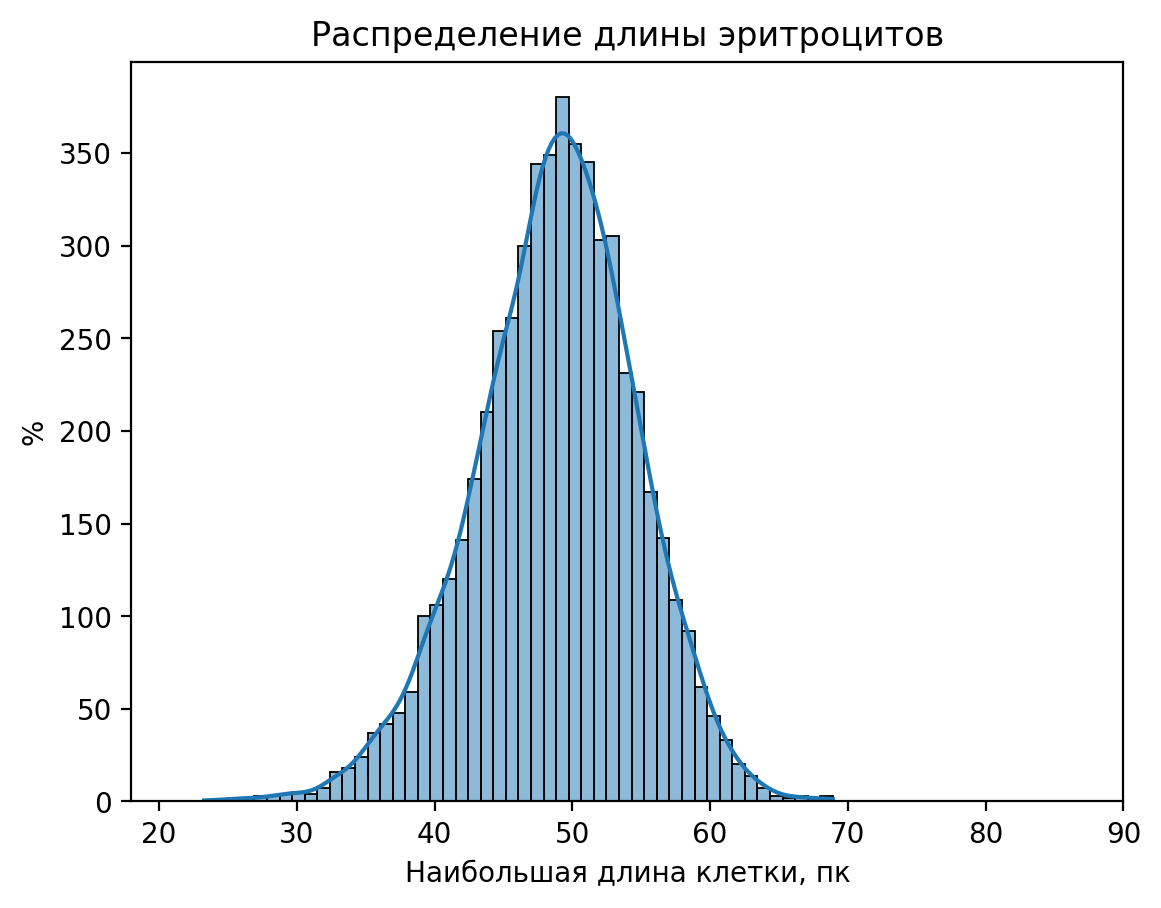

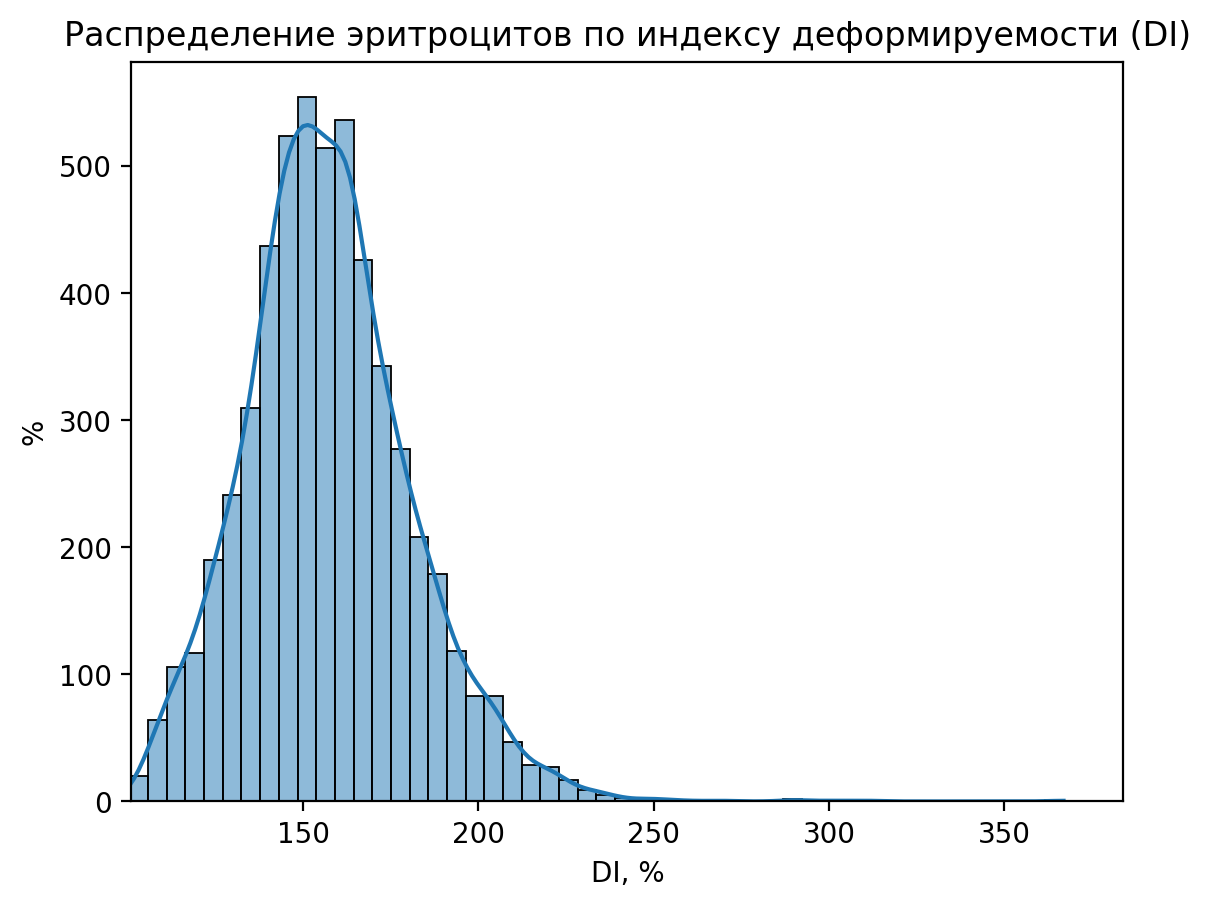

Обработано 33 изображений
Всего клеток на изображениях:  5478


In [133]:
human_cells_count = 0 # количество клеток на всех изображениях
areas = []
lengths = []
widths = []
DI = []

for stardist_masks_file in tqdm(stardist_masks_files):
    image_filename = os.path.basename(stardist_masks_file)[:-4] # имя файла без расширения
    
    # чтение масок
    masks = Image.open(stardist_masks_file)
    masks = np.asarray(masks)
    human_cells_count += masks.max()
    
    # нахождение контуров
    for i in range(1, masks.max()+1):
        mask = masks.copy()
        mask[mask != i] = 0
        mask[mask == i] = 1
        mask = np.array(mask, np.uint8)
        contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
        cnt = contour[0]
        try:
            ellipse = cv2.fitEllipse(cnt) # проверка, достаточно ли точек
        except Exception:
            continue
        areas.append(area_of_rbc(cnt))
        lengths.append(length_of_rbc(cnt))
        widths.append(width_of_rbc(cnt))
        DI.append(lengths[-1]/widths[-1]*100)

# Распределение по площадям
bins = 50
sns.histplot(areas, bins=bins, kde=True)
plt.title('Распределение площадей эритроцитов')
plt.xlabel('Площадь, пкс^2')
plt.ylabel('%')
plt.xlim(area_limits)
plt.show()

# Распределение по длинам
sns.histplot(lengths, bins=bins, kde=True)
plt.title('Распределение длины эритроцитов')
plt.xlabel('Наибольшая длина клетки, пк')
plt.ylabel('%')
plt.xlim(length_limits)
plt.show()

# Распределение по DI
sns.histplot(DI, bins=bins, kde=True)
plt.title('Распределение эритроцитов по индексу деформируемости (DI)')
plt.xlabel('DI, %')
plt.ylabel('%')
plt.xlim(DI_limits)
plt.show()

print(f"Обработано {len(stardist_masks_files)} изображений")
print('Всего клеток на изображениях: ', human_cells_count)

In [115]:
print("Диапазон (areas): ", round(min(areas)), "-", round(max(areas)))
print("Диапазон (lengths): ", round(min(lengths)), "-", round(max(lengths)))
print("Диапазон (DI): ", round(min(DI)), "-", round(max(DI)))

Диапазон (areas):  422 - 1688
Диапазон (lengths):  26 - 69
Диапазон (DI):  112 - 240
